<a href="https://colab.research.google.com/github/sayid-alt/student-performance-factor-analysis/blob/main/%5BClustering%5D_Submission_Akhir_BMLP_Sayid_Muhammad_Heykal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Intro to Project**


**Dataset Source**:  [![kaggle](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Kaggle_Logo.svg/50px-Kaggle_Logo.svg.png)](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors) <br>
**Objective**: The primary aim of this analysis is to perform clustering on the provided student dataset and assign each student to an appropriate, well-defined cluster. By applying clustering techniques, we aim to segment students based on relevant characteristics, which will aid in understanding patterns, behaviors, or other distinct groupings among the students.

**Goals**: <br>
1. **Cluster Prediction**: Using clustering algorithms, identify the underlying groups within the dataset and accurately predict the clusters each student belongs to.
2. **Cluster Labeling**: Once clusters are formed, label each student based on their assigned cluster, providing insights into the distinct features or traits associated with each group.

This analysis will contribute to identifying potential factors influencing student behavior or performance, which can assist educational institutions in tailoring their approaches to meet diverse student needs.

# **2. Import Library**

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import time
import warnings
warnings.filterwarnings('ignore')

# **3. Memuat Dataset**

The dataset has been stored in a GitHub repository to provide convenient access for analysis within the accompanying notebook. To visit github repo, please click [github](https://github.com/sayid-alt/student-performance-factor-analysis)

In [145]:
RAW_FILE = 'https://raw.githubusercontent.com/sayid-alt/student-performance-factor-analysis/refs/heads/main/datasets/StudentPerformanceFactors.csv'

def fetch_dataset(link=RAW_FILE):
  download_link = urllib.request.urlretrieve(link, 'clustering.csv')
  print(f'\nsuccessfull download {download_link}')
  df = pd.read_csv('clustering.csv', encoding='utf-8')
  return df

In [146]:
df = fetch_dataset()
df.head()


successfull download ('clustering.csv', <http.client.HTTPMessage object at 0x7965c8db1360>)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


# **4. Exploratory Data Analysis (EDA)**

In this stage, we will perform Exploratory Data Analysis (EDA) to understand the characteristics of the dataset. The purpose of EDA is to:
1. Understand the Data Structure
  * Review the number of rows and columns in the dataset.
  * Examine the data types of each column (numerical or categorical).
2. Handle Missing Data
  * Identify and analyze any missing values in the dataset
  * Determine the necessary steps to handle missing data, such as filling or removing them.
3. Analyze Distribution and Correlation
  * Analyze the distribution of numerical variables using descriptive statistics and visualizations such as histograms or box plots.
  * Check the relationships between variables using a correlation matrix or scatter plots.
4. Data Visualization
  * Create basic visualizations such as distribution plots and bar charts for categorical variables.
  * Use heatmaps or pair plots to analyze the correlations among variables.

The goal of EDA is to gain initial, in-depth insights into the data and determine the next steps in analysis or modeling.

In [147]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

(None, (6607, 20))

To unify the column indices, we will set all column names to lowercase.

In [148]:
df.columns = df.columns.str.lower()

print(df.columns.tolist())

['hours_studied', 'attendance', 'parental_involvement', 'access_to_resources', 'extracurricular_activities', 'sleep_hours', 'previous_scores', 'motivation_level', 'internet_access', 'tutoring_sessions', 'family_income', 'teacher_quality', 'school_type', 'peer_influence', 'physical_activity', 'learning_disabilities', 'parental_education_level', 'distance_from_home', 'gender', 'exam_score']


## 4.1 Data Cleansing

In this section, we will focus on cleaning the dataset to ensure it is prepared for use in the model. The cleaning process includes the following steps:
1. Formatting the data
2. Defining a strategy for handling missing values
3. Removing duplicates
4. Managing outliers

In [149]:
df_cleaned = df.copy()

In [150]:
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

print(f'Number of features: {len(categorical_cols) + len(numerical_cols)}')
print(f'Number of numerical features: {len(numerical_cols)}')
print(f'Number of categorical features: {len(categorical_cols)}\n')
print(f'List of categorical features:\n{categorical_cols}\n')
print(f'list of numerical features:\n{numerical_cols}')

Number of features: 20
Number of numerical features: 7
Number of categorical features: 13

List of categorical features:
['parental_involvement', 'access_to_resources', 'extracurricular_activities', 'motivation_level', 'internet_access', 'family_income', 'teacher_quality', 'school_type', 'peer_influence', 'learning_disabilities', 'parental_education_level', 'distance_from_home', 'gender']

list of numerical features:
['hours_studied', 'attendance', 'sleep_hours', 'previous_scores', 'tutoring_sessions', 'physical_activity', 'exam_score']


In [151]:
df_cleaned[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
hours_studied,6607.0,19.975329,5.990594,1.0,16.0,20.0,24.0,44.0
attendance,6607.0,79.977448,11.547475,60.0,70.0,80.0,90.0,100.0
sleep_hours,6607.0,7.029060,1.468120,4.0,6.0,7.0,8.0,10.0
previous_scores,6607.0,75.070531,14.399784,50.0,63.0,75.0,88.0,100.0
tutoring_sessions,6607.0,1.493719,1.230570,0.0,1.0,1.0,2.0,8.0
physical_activity,6607.0,2.967610,1.031231,0.0,2.0,3.0,4.0,6.0
exam_score,6607.0,67.235659,3.890456,55.0,65.0,67.0,69.0,101.0


In [152]:
df_cleaned[categorical_cols].describe().T

,count,unique,top,freq
parental_involvement,6607,3,Medium,3362
access_to_resources,6607,3,Medium,3319
extracurricular_activities,6607,2,Yes,3938
motivation_level,6607,3,Medium,3351
internet_access,6607,2,Yes,6108
family_income,6607,3,Low,2672
teacher_quality,6529,3,Medium,3925
school_type,6607,2,Public,4598
peer_influence,6607,3,Positive,2638
learning_disabilities,6607,2,No,5912


**==== Inference ====:**<br>
As the describe output shows that numerical columns can be inferenced as follows:<br>
There is the high gap between values of q3 (75%) and max value in columns:

  - **Hours_Studied**: Third quartile is 24, and max value is 44. where the data can be said as skewed
  - **Tutoring_Sessions**: As the third quartile has a high gap between the max value, the data can be said as skewed.
  - **Exam_Score**: the max values is 101, indicates the false input which the max should not be greater than 100. and as the third quartile is 67 has a higher gap to the max values.

**STRATEGY**
1. The most reasonable for 101 is to replace to 100. Where the admin might faulty inputed the data
2. We will checking the behaviour of columns of `tutoring_sessions` and `exam_score` to identify the kind of distribution
3. We will check the missing values and figure out how to hanlde those misisng values properly.
  

In [153]:
# replace the exam score that 101 into 100
df_cleaned['exam_score'] = df_cleaned['exam_score'].replace(101, 100)

# check for replacement
df_cleaned['exam_score'][df_cleaned['exam_score'] > 90].value_counts().reset_index().sort_values(by='exam_score', ascending=True)

,exam_score,count
8,91,1
4,92,2
7,93,2
0,94,4
6,95,2
9,96,1
1,97,3
2,98,3
5,99,2
3,100,2


**Now let's checking for the missing values!**

In [154]:
missing_values = df_cleaned.isnull().sum()
percentage_missing_values = (missing_values / df_cleaned.shape[0]) * 100

print(f'Total number of missing values: {missing_values.sum()}')
print(f'Percentage of missing values: {percentage_missing_values.sum():.2f}%\n')

missing_values_df = pd.DataFrame(percentage_missing_values[missing_values>0], columns=['percentage_missing_values'])
missing_values_df['number_of_missing_values'] = missing_values[missing_values>0]
missing_values_df

Total number of missing values: 235
Percentage of missing values: 3.56%



,percentage_missing_values,number_of_missing_values
teacher_quality,1.180566,78
parental_education_level,1.362192,90
distance_from_home,1.014076,67


**INFERENCE**<br>
There is **235** missing values, or **3.56%** of the dataset 😀. Therefore, as we seen the amount of the missing values is not high, and as considered that imputing the missing value would cause bias and inacurate data which would affect our model as well.

**STRATEGY** <br>
- Simply drop the rows with missing values

In [155]:
# Drop the null values
df_cleaned.dropna(axis=0, inplace=True)

# check for missing values
print(f'Total number of missing values: {df_cleaned.isnull().sum().sum()}')
missing_values = df_cleaned.isnull().sum()
missing_values_df = pd.DataFrame(percentage_missing_values[missing_values>0], columns=['percentage_missing_values'])
missing_values_df['number_of_missing_values'] = missing_values[missing_values>0]
missing_values_df

Total number of missing values: 0


,percentage_missing_values,number_of_missing_values


In [156]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   hours_studied               6378 non-null   int64 
 1   attendance                  6378 non-null   int64 
 2   parental_involvement        6378 non-null   object
 3   access_to_resources         6378 non-null   object
 4   extracurricular_activities  6378 non-null   object
 5   sleep_hours                 6378 non-null   int64 
 6   previous_scores             6378 non-null   int64 
 7   motivation_level            6378 non-null   object
 8   internet_access             6378 non-null   object
 9   tutoring_sessions           6378 non-null   int64 
 10  family_income               6378 non-null   object
 11  teacher_quality             6378 non-null   object
 12  school_type                 6378 non-null   object
 13  peer_influence              6378 non-null   object
 1

Once The missing values has been removed, We will visualize the distribution for each columns and identify the correlation between them

## 4.2 Distribution and Correlation

The `tutoring_sessions` and the `exam_scores` shows the higher gap between median of 75% data or third quartile and the max. This indicates the skewed distribution of the data. Either the data between Q3 and max are very small distribution which the possibilities might happened as follow:
- The `tutoring scores` are tend to be small distribution as the value get higher, means that the students are more likely to have a short amount of tutoring sessions.
- The `exam_scores` are also tend to be small distribution as the value get higher, means that the students that get the higher score is a little amount. This might have a correlation between student whom take more tutoring sessions.

For further inferences, let's plot the correlation beteween those features

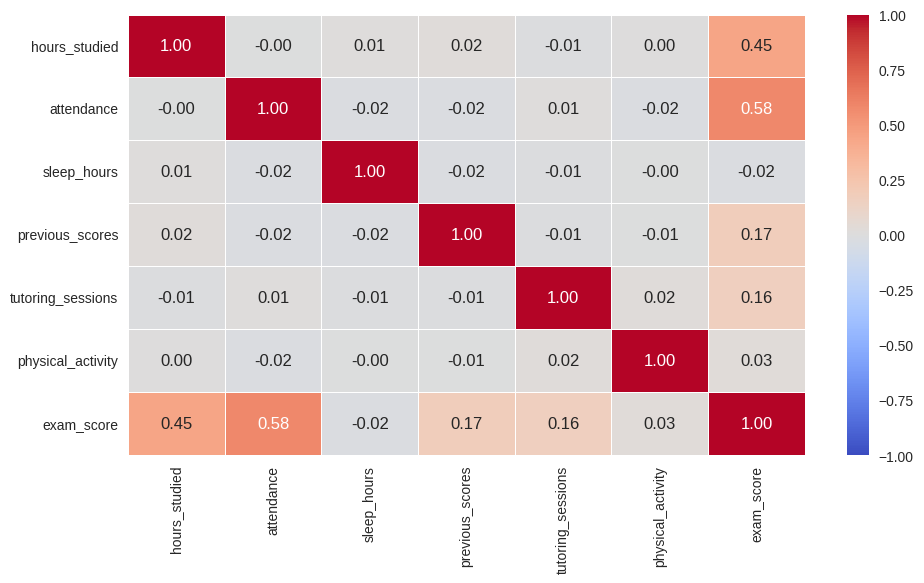

In [157]:
numerical_corr = df_cleaned[numerical_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f',vmax=1, vmin=-1)
plt.tight_layout()
plt.show()

This is interesing one. The correlation between numerical features are not too strong, except the correlation between exam_score with attendance, previous scores, tutoring sessions. has a higher positive correlation between them. The `tutoring_sessions` has a positive correlation between `exam_score`with `0.16`. This might not be a strong correlation as we see the value. But it's more correlated than the other features. And new discovering that column `attendance` has the strong correlation to `exam_score`

In [158]:
# check deeper to the distribution of exam score
print(f'Distribution of exam score: ')
df_cleaned['exam_score'].value_counts().reset_index().sort_values(by='exam_score', ascending=True)

Distribution of exam score: 


,exam_score,count
42,55,1
43,56,1
21,57,4
17,58,21
16,59,39
14,60,75
11,61,166
10,62,261
8,63,350
6,64,478


Above we can infer that the higher score the smaller distribution of the student

Distribution of tutoring_sessions:
    tutoring_sessions  count
0                  0   1458
1                  1   2111
2                  2   1586
3                  3    800
4                  4    296
5                  5    101
6                  6     18
7                  7      7
8                  8      1


<Axes: xlabel='tutoring_sessions', ylabel='count'>

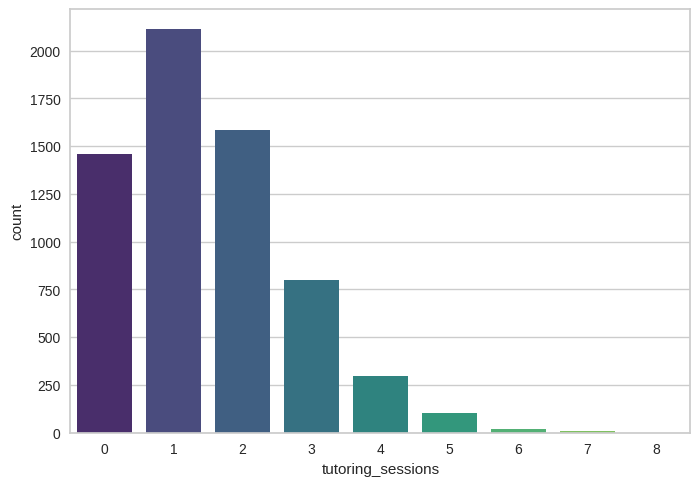

In [159]:
tutoring_sessions_distribution = df_cleaned["tutoring_sessions"].value_counts().reset_index().sort_values(
    by="tutoring_sessions", ascending=True
).reset_index()

tutoring_sessions_distribution.drop(columns=['index'], inplace=True)


print(f'Distribution of tutoring_sessions:\n {tutoring_sessions_distribution}')
sns.countplot(x='tutoring_sessions', data=df_cleaned, palette='viridis') # plot the distribution

As we can see the higher tutoring sessions tends to lower the number of students. This may happend because some students have a higher motivation or they are need the tutoring sessions the most

In [160]:
def dist_plot(df, cols, types='hist'):
    ncols = 4
    nrows = len(cols) // ncols + 1

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*4))
    axes = axes.flatten() # flatten the axes for indices

    for i, col in enumerate(cols):
        if types == 'hist':
            sns.histplot(df, x=col, ax=axes[i], kde=True)
        elif types == 'box':
            sns.boxplot(df, x=col, ax=axes[i])
        axes[i].set_title(f'{col} distribution')
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()

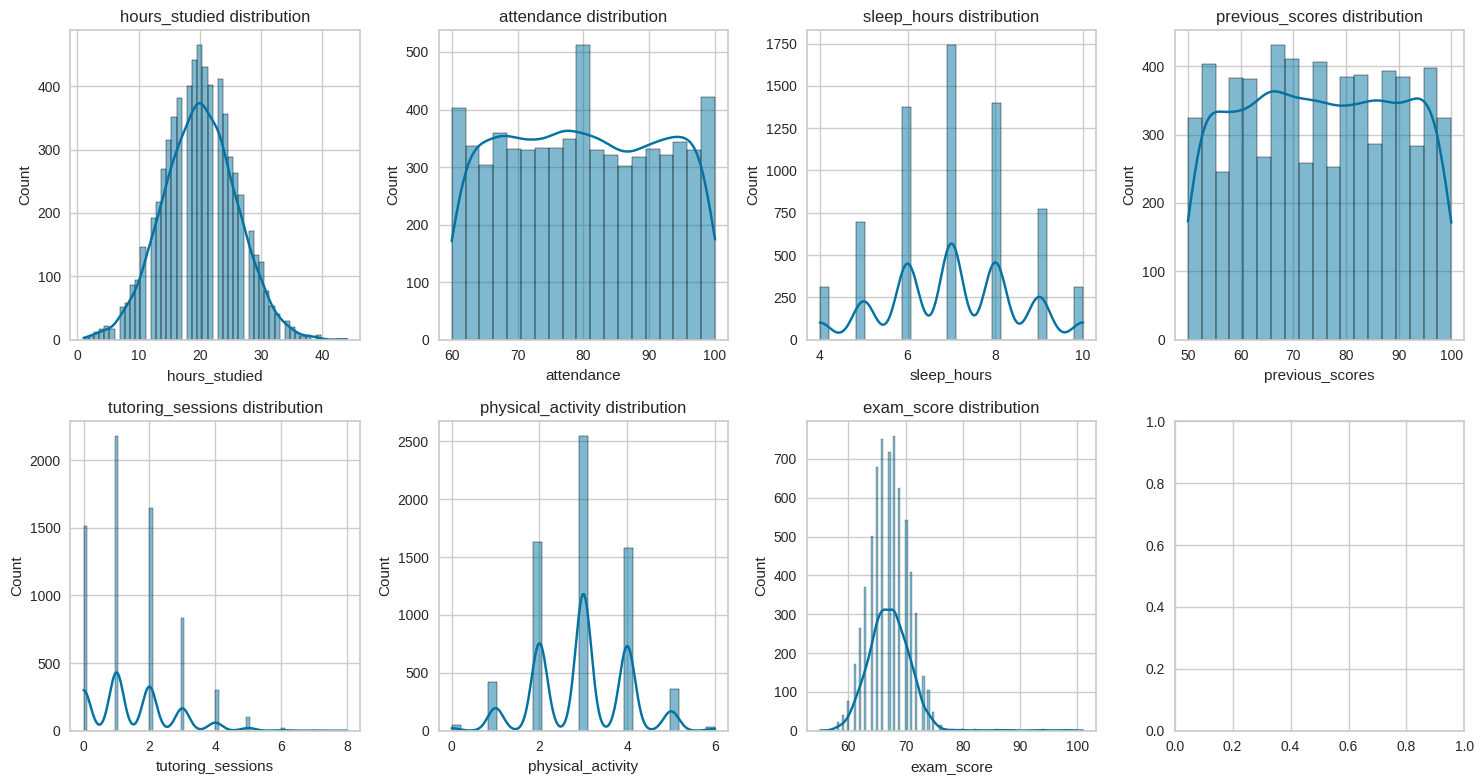

In [161]:
dist_plot(df, numerical_cols)

As we said that `tutoring_sessions` and `exam_score` are have high gap between values of q3 (75%) and max value. We need to know further if there is the value between the gap or there is an absent value between them. Another meaning is that the value is existed between the gap, but just the litle amount of values.

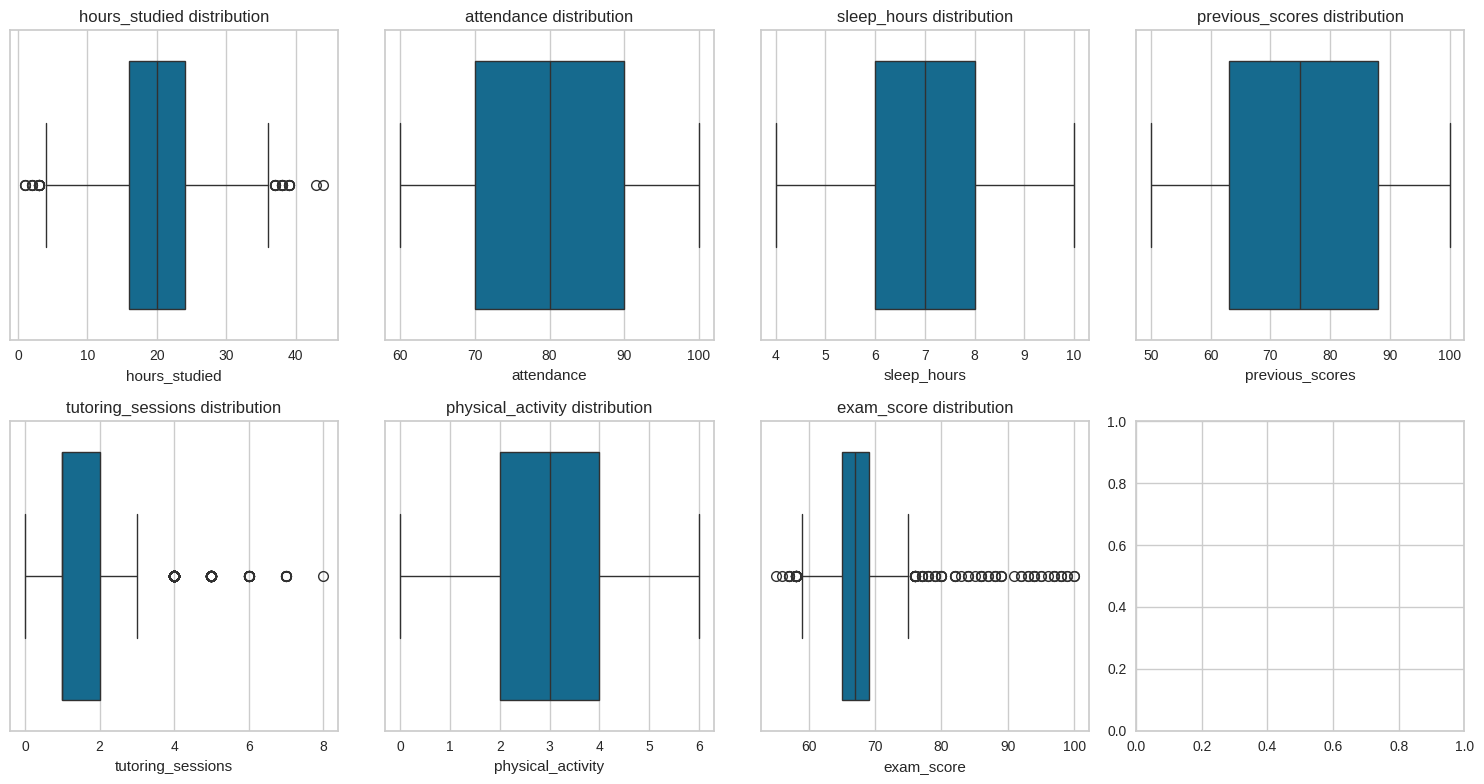

In [162]:
dist_plot(df_cleaned, numerical_cols, types='box')

There is some columns indicated as an outlier values. We have an option to handle this.
1. Drop the outlier values, This might not be a good idea. Because it's potentially to remove the valuable information. which the outliers here are occurs as the different type of student behaviours.
2. Normalize or scalling the features

However, we'll normalize them or scaled them in the data preprocessing.

In [163]:
desc_categorical = df_cleaned[categorical_cols].describe().T
desc_categorical['freq_percentage(%)'] = desc_categorical['freq'] / df_cleaned.shape[0] * 100
desc_categorical

,count,unique,top,freq,freq_percentage(%)
parental_involvement,6378,3,Medium,3251,50.972092
access_to_resources,6378,3,Medium,3204,50.235183
extracurricular_activities,6378,2,Yes,3807,59.689558
motivation_level,6378,3,Medium,3237,50.752587
internet_access,6378,2,Yes,5893,92.395735
family_income,6378,3,Low,2582,40.48291
teacher_quality,6378,3,Medium,3826,59.987457
school_type,6378,2,Public,4434,69.520226
peer_influence,6378,3,Positive,2553,40.028222
learning_disabilities,6378,2,No,5710,89.526497


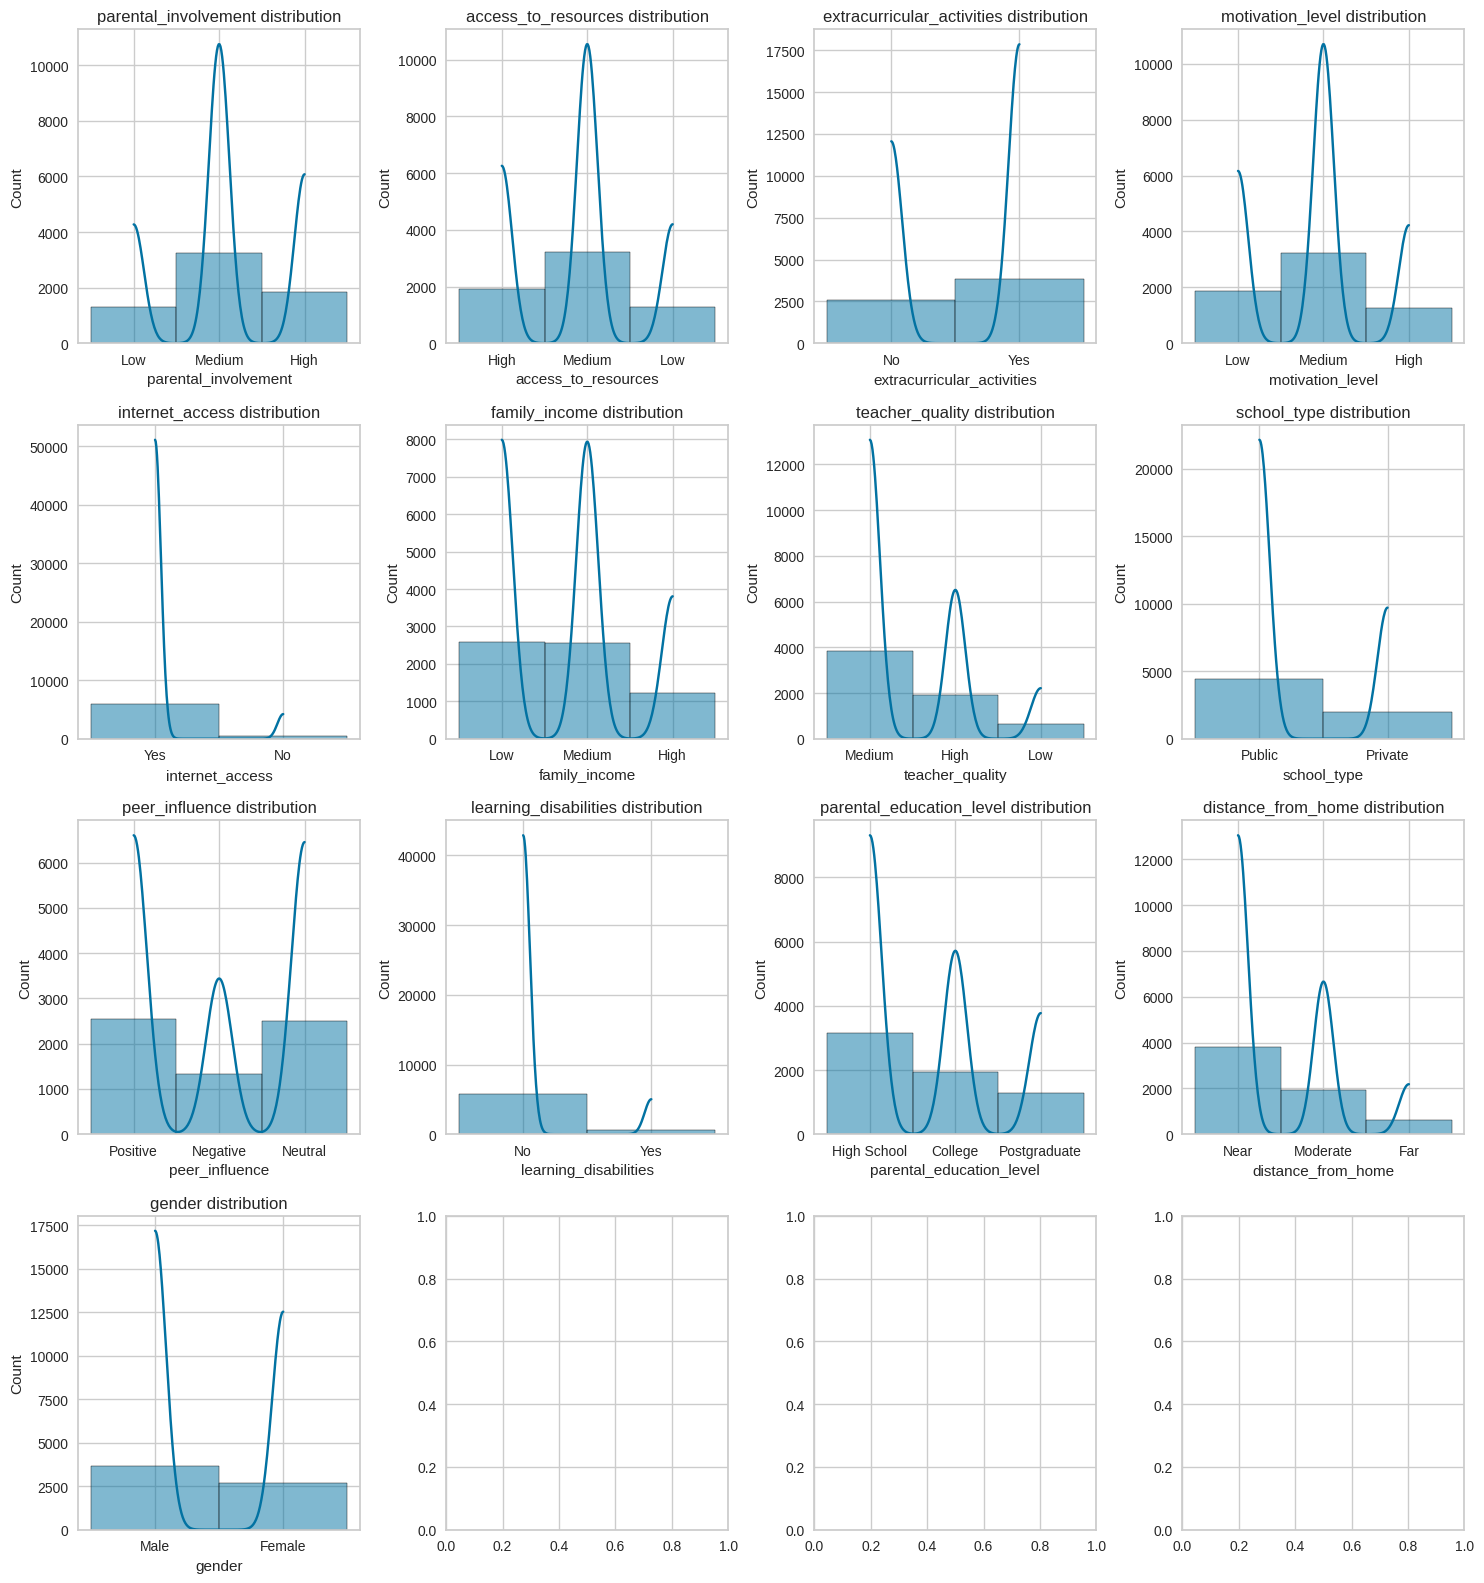

In [164]:
dist_plot(df_cleaned, categorical_cols)

In [165]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   hours_studied               6378 non-null   int64 
 1   attendance                  6378 non-null   int64 
 2   parental_involvement        6378 non-null   object
 3   access_to_resources         6378 non-null   object
 4   extracurricular_activities  6378 non-null   object
 5   sleep_hours                 6378 non-null   int64 
 6   previous_scores             6378 non-null   int64 
 7   motivation_level            6378 non-null   object
 8   internet_access             6378 non-null   object
 9   tutoring_sessions           6378 non-null   int64 
 10  family_income               6378 non-null   object
 11  teacher_quality             6378 non-null   object
 12  school_type                 6378 non-null   object
 13  peer_influence              6378 non-null   object
 1

In [166]:
df_cleaned.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hours_studied,6378.0,NaN,NaN,NaN,19.977109,5.98546,1.0,16.0,20.0,24.0,44.0
attendance,6378.0,NaN,NaN,NaN,80.020853,11.550723,60.0,70.0,80.0,90.0,100.0
parental_involvement,6378,3,Medium,3251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
access_to_resources,6378,3,Medium,3204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extracurricular_activities,6378,2,Yes,3807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sleep_hours,6378.0,NaN,NaN,NaN,7.034964,1.468033,4.0,6.0,7.0,8.0,10.0
previous_scores,6378.0,NaN,NaN,NaN,75.066165,14.400389,50.0,63.0,75.0,88.0,100.0
motivation_level,6378,3,Medium,3237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
internet_access,6378,2,Yes,5893,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tutoring_sessions,6378.0,NaN,NaN,NaN,1.495296,1.233984,0.0,1.0,1.0,2.0,8.0


# **5. Data Preprocessing**

At this stage, data preprocessing is an important step to ensure data quality before being used in a machine learning model. Raw data often contains empty values, duplicates, or inconsistent value ranges, which can affect model performance. Therefore, this process aims to clean and prepare the data for optimal analysis.

The following are the steps that need to be done, but are **not limited** to:
1. Removing or Handling Empty Data (Missing Values)
2. Removing Duplicate Data
3. Normalization or Feature Standardization
4. Outlier Detection and Handling
5. Categorical Data Encoding
6. Binning (Data Grouping)

## **5.1. Checking Duplicated**

In [167]:
total_duplicated = df_cleaned.duplicated().sum()

if total_duplicated > 0:
    print(f'total duplicated rows: {total_duplicated}')
else:
    print(f'total duplicated rows: {total_duplicated}')
    print(f'No duplicated rows!')

total duplicated rows: 0
No duplicated rows!


## **5.2 Handling Outliers**

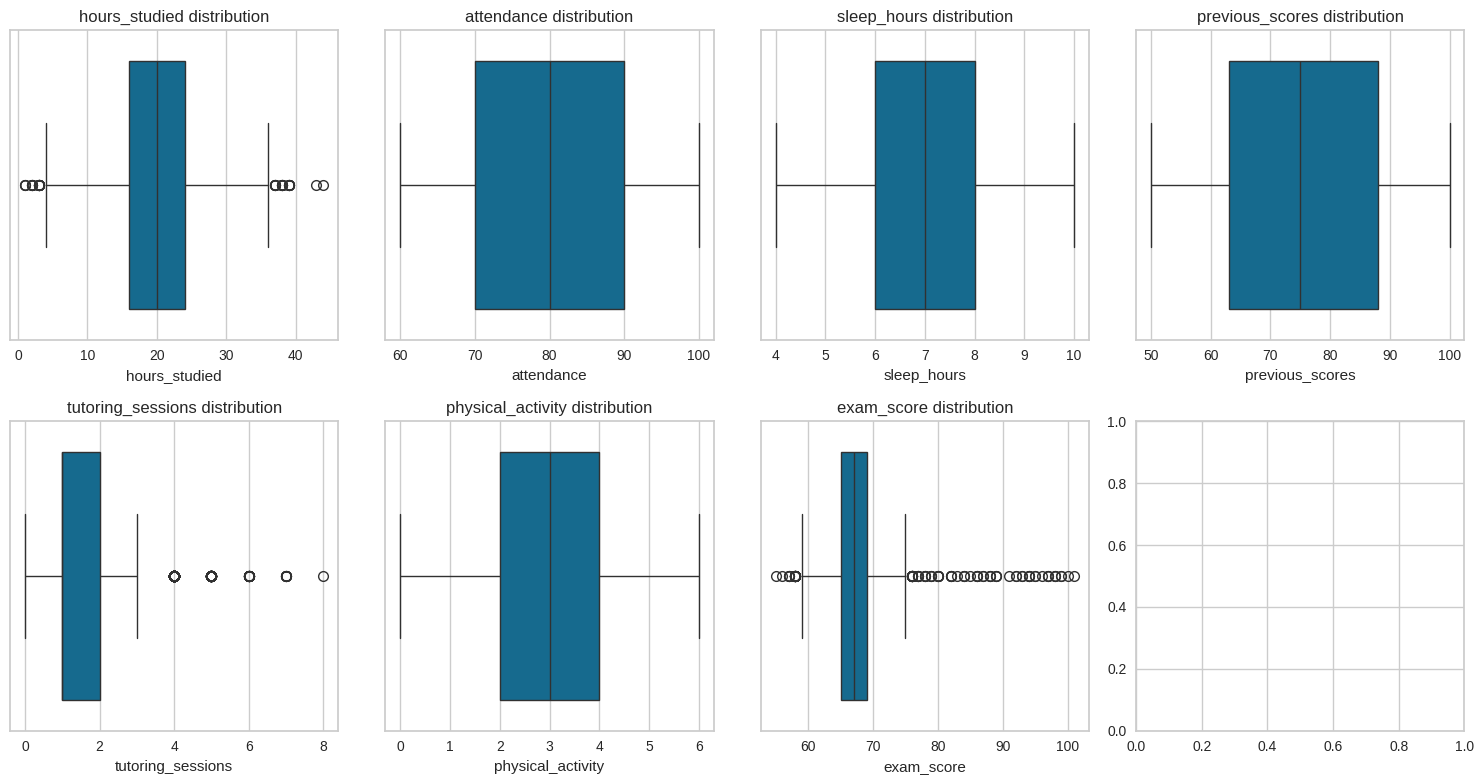

In [168]:
dist_plot(df, numerical_cols, types='box')

Outliers on numerical features above is indicated for `tutoring_sessions`, `exam_score`, and `hours_studied` due to various demography of students. This may require necessery actions to handle it in the right way. Say if we want to remove it, it would be removed some important demography information.

**STRATEGY**<br>
- Convert the numerical features to the categorical features with binning method. Reasons for this, that the information we need is just the cluster the spesific characteristics of students, not the detail of their scores. so we can group the students with score in range of 70-79 as `B` indicator, and so on.
- Here we'll use the For the `exam_score` `cut` method. to binning the numerical features to the categorical features.
    - exam_score  80 – 100 = A
    - exam_score  70 – 79 = B
    - exam_score  60 – 69 = C
    - exam_score  60 = D
- For the `hours_studied` we'll use the `cut` metdoh as well. And we'll divide them as follows:
    - hours_studided < 10 = low
    - hours_studided < 30 = medium
    - hours_studided > 30 = high
- We'll use for the `tutoring_sessions` cut method as well. And we'll divide them as follows:
    - tutoring_sessions < 2 = low
    - tutoring_sessions < 6 = medium
    - tutoring_sessions > 6 = high
- The result of the binning would become the category datatype, we should convert it back to object datatype for unified data type.

Updated categorical columns: ['parental_involvement', 'access_to_resources', 'extracurricular_activities', 'motivation_level', 'internet_access', 'family_income', 'teacher_quality', 'school_type', 'peer_influence', 'learning_disabilities', 'parental_education_level', 'distance_from_home', 'gender', 'hours_studied_indicator', 'exam_score_indicator', 'tutoring_sessions_indicator']


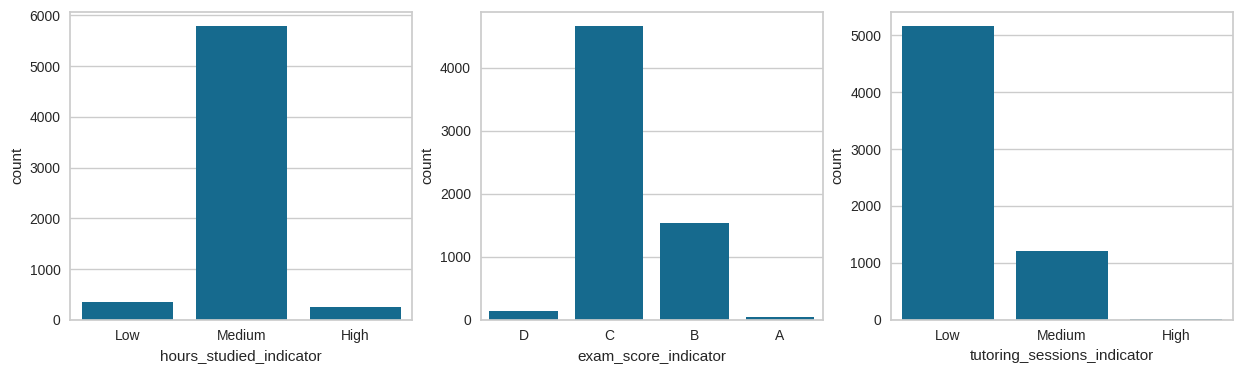

In [169]:
# set binning and store in new columns labeled as indocator
df_cleaned['exam_score_indicator'] = pd.cut(df_cleaned['exam_score'], bins=[-1, 60, 69, 79, 100], labels=['D', 'C', 'B', 'A'])
df_cleaned['hours_studied_indicator'] = pd.cut(df_cleaned['hours_studied'], bins=[-1, 10, 30, 60], labels=['Low', 'Medium', 'High'])
df_cleaned['tutoring_sessions_indicator'] = pd.cut(df_cleaned['tutoring_sessions'], bins=[-1, 2, 6, 10], labels=['Low', 'Medium', 'High'])

# show the distribution of the new categorical columns
fig, axes = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)
axes = axes.flatten()

for i, col in enumerate(['hours_studied_indicator', 'exam_score_indicator', 'tutoring_sessions_indicator']):
    sns.countplot(x=col, data=df_cleaned, ax=axes[i])


# Update the categorical columns list
new_categorical_cols = ['hours_studied_indicator', 'exam_score_indicator', 'tutoring_sessions_indicator']
for new_col in new_categorical_cols:
    categorical_cols.append(new_col)
print(f'Updated categorical columns: {categorical_cols}')

# convert category datatype to object
for col in df_cleaned[categorical_cols].select_dtypes(['category']).columns:
    df_cleaned[col] = df_cleaned[col].astype('object')

In [170]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   hours_studied                6378 non-null   int64 
 1   attendance                   6378 non-null   int64 
 2   parental_involvement         6378 non-null   object
 3   access_to_resources          6378 non-null   object
 4   extracurricular_activities   6378 non-null   object
 5   sleep_hours                  6378 non-null   int64 
 6   previous_scores              6378 non-null   int64 
 7   motivation_level             6378 non-null   object
 8   internet_access              6378 non-null   object
 9   tutoring_sessions            6378 non-null   int64 
 10  family_income                6378 non-null   object
 11  teacher_quality              6378 non-null   object
 12  school_type                  6378 non-null   object
 13  peer_influence               6378 non-

## **5.2 Scaling**

Before the features feed into the model, we need to do some preprocessing of features. Which we'll do as follows:
* The numerical features has to be scaled to the same distribution in order to make a data more robust to feed into machine learning model.
* The categorical columns need to be encoded. Because the model machine learning requires the data to be in numerical form.

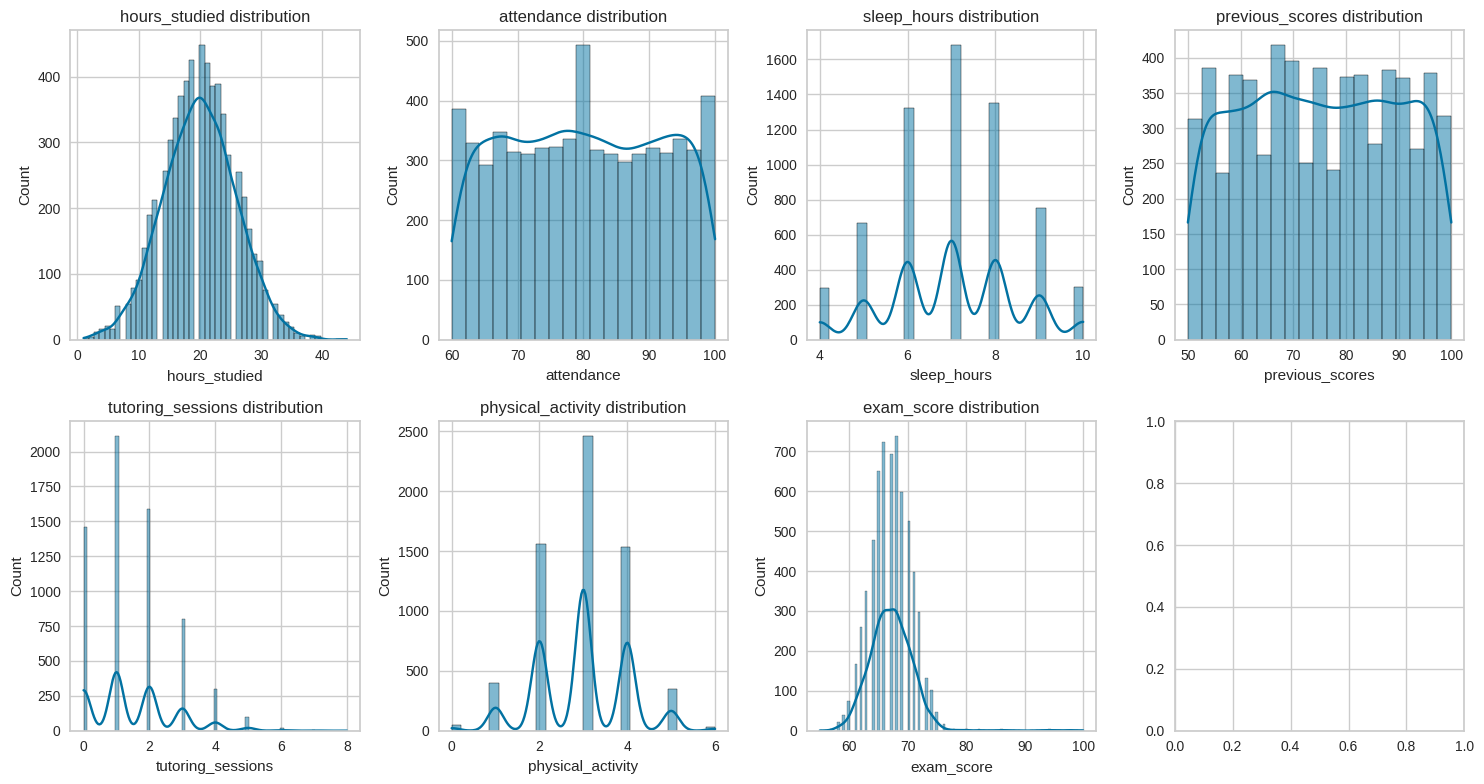

In [171]:
dist_plot(df_cleaned, numerical_cols)

<Axes: >

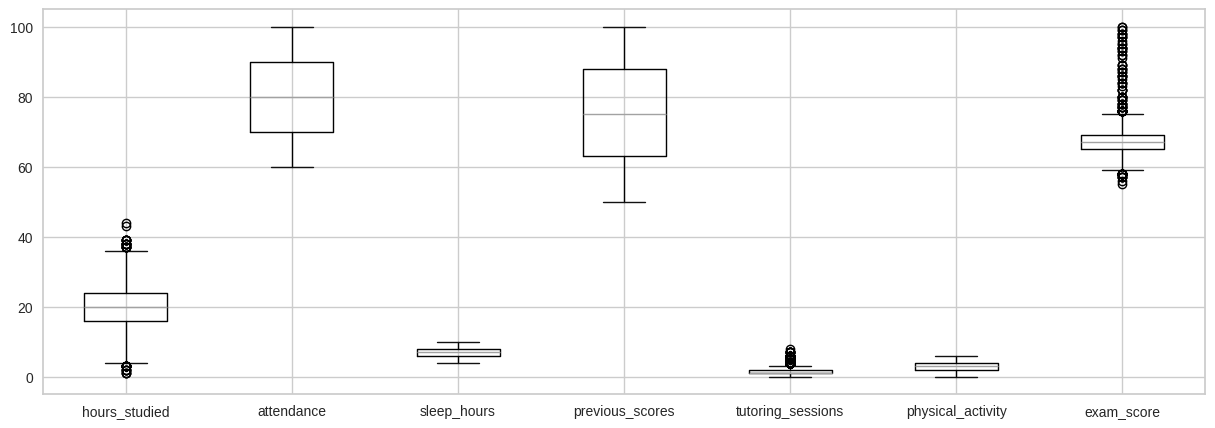

In [172]:
# Looking for numerical features to be scaled
plt.figure(figsize=(15,5))
df_cleaned[numerical_cols].boxplot()

Boxplot above shows that the features has a lot of outliers. means the data is more skewed. <br>
<br>
**STRATEGY**
- Standardize the data using StandardScaler to scale the values within a range of 0 to 1.

In [173]:
df_scaled = df_cleaned.copy()
scaler = MinMaxScaler()
df_scaled[numerical_cols] = scaler.fit_transform(df_cleaned[numerical_cols])
df_scaled[numerical_cols]

,hours_studied,attendance,sleep_hours,previous_scores,tutoring_sessions,physical_activity,exam_score
0,0.511628,0.600,0.500000,0.46,0.000,0.500000,0.266667
1,0.418605,0.100,0.666667,0.18,0.250,0.666667,0.133333
2,0.534884,0.950,0.500000,0.82,0.250,0.666667,0.422222
3,0.651163,0.725,0.666667,0.96,0.125,0.666667,0.355556
4,0.418605,0.800,0.333333,0.30,0.375,0.666667,0.333333
...,...,...,...,...,...,...,...
6602,0.558140,0.225,0.500000,0.52,0.125,0.333333,0.288889
6603,0.511628,0.400,0.666667,0.62,0.375,0.333333,0.311111
6604,0.441860,0.750,0.333333,0.30,0.375,0.333333,0.288889
6605,0.209302,0.650,0.333333,0.82,0.250,0.500000,0.288889


Numerical Distribution after scaling


<Axes: >

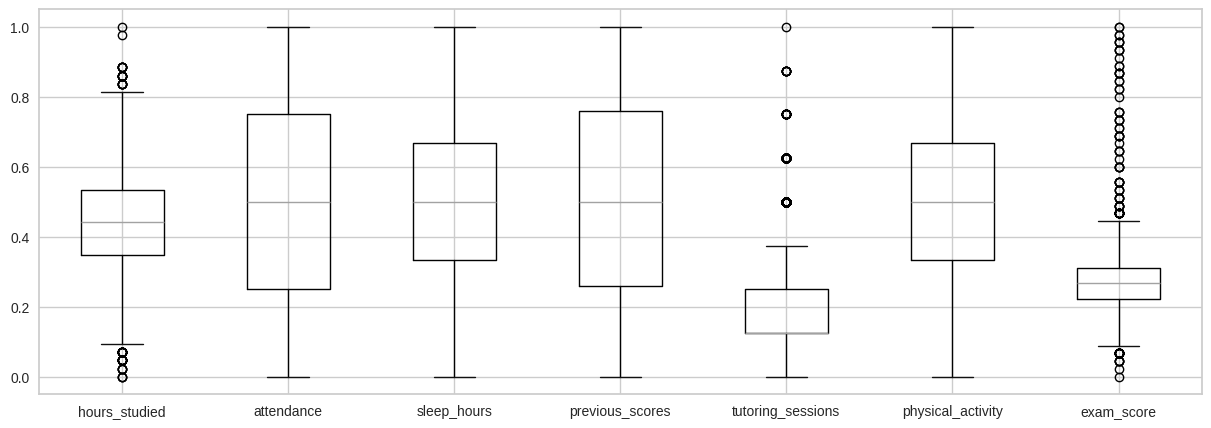

In [174]:
# Looking for numerical features to be scaled
print(f'Numerical Distribution after scaling')
plt.figure(figsize=(15,5))
df_scaled[numerical_cols].boxplot()

## **5.3. Handling Outliers**

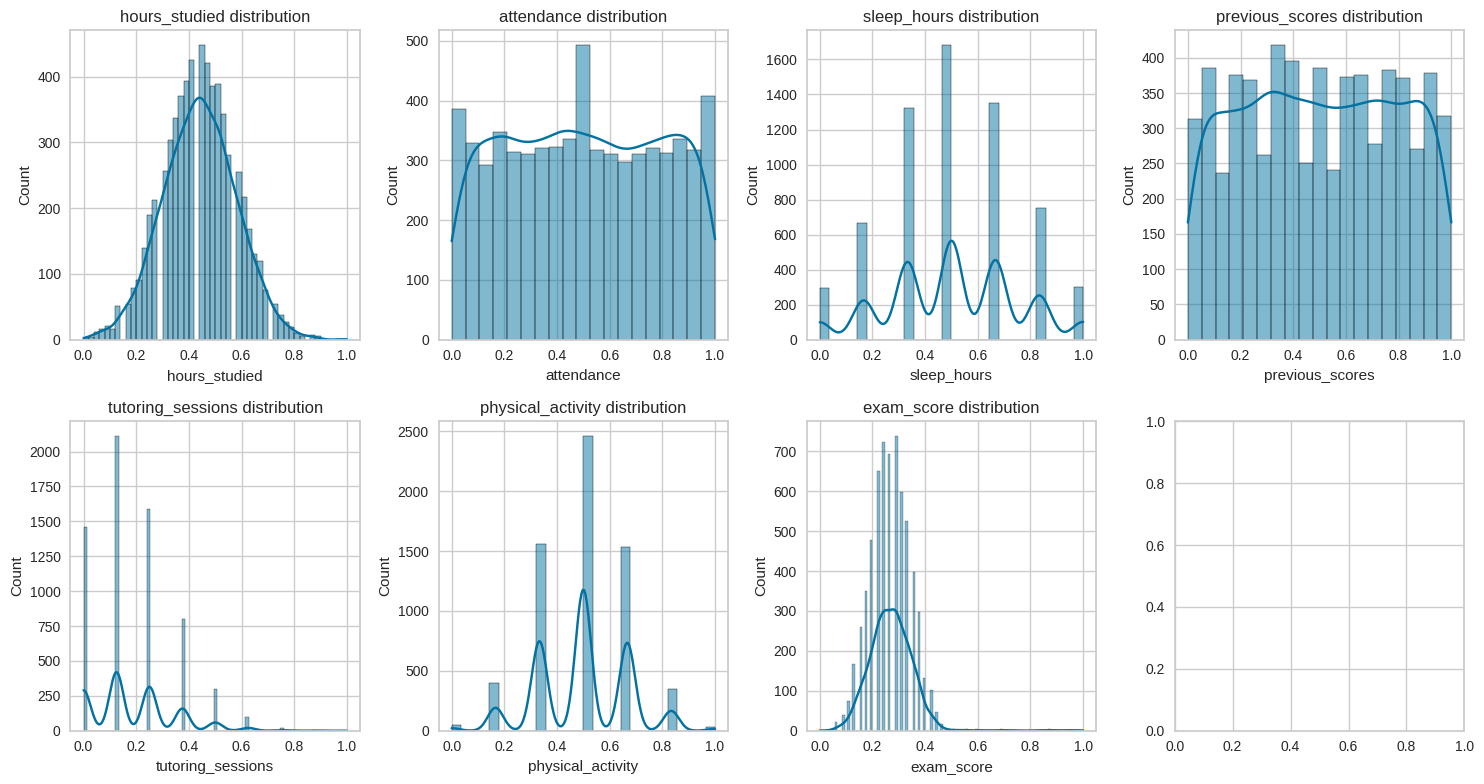

In [175]:
dist_plot(df_scaled, numerical_cols)

In [176]:
df_scaled[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
hours_studied,6378.0,0.441328,0.139197,0.0,0.348837,0.441860,0.534884,1.0
attendance,6378.0,0.500521,0.288768,0.0,0.250000,0.500000,0.750000,1.0
sleep_hours,6378.0,0.505827,0.244672,0.0,0.333333,0.500000,0.666667,1.0
previous_scores,6378.0,0.501323,0.288008,0.0,0.260000,0.500000,0.760000,1.0
tutoring_sessions,6378.0,0.186912,0.154248,0.0,0.125000,0.125000,0.250000,1.0
physical_activity,6378.0,0.495453,0.171488,0.0,0.333333,0.500000,0.666667,1.0
exam_score,6378.0,0.272266,0.086953,0.0,0.222222,0.266667,0.311111,1.0


The distribution looks much better now, and if we look at the standard deviation is close to 1 means the data is more normal. but still have a lot of outliers. <br>

**STRATEGY**
- The outliers are would not to be removed, because it would remove some unique information such as the `exam_score` that greater than 80 is counted as outliers. but it's important information for model to recognize it.
- To handle this we would use the model that more robust with the outliers such as `DBSCAN` (Density-based spatial clustering) or `K-medoids` for Clustering and Random Forest `RF` or `SVM`

## **5.4 Encoding the categorical features**

In [177]:
df_scaled[categorical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   parental_involvement         6378 non-null   object
 1   access_to_resources          6378 non-null   object
 2   extracurricular_activities   6378 non-null   object
 3   motivation_level             6378 non-null   object
 4   internet_access              6378 non-null   object
 5   family_income                6378 non-null   object
 6   teacher_quality              6378 non-null   object
 7   school_type                  6378 non-null   object
 8   peer_influence               6378 non-null   object
 9   learning_disabilities        6378 non-null   object
 10  parental_education_level     6378 non-null   object
 11  distance_from_home           6378 non-null   object
 12  gender                       6378 non-null   object
 13  hours_studied_indicator      6378 non-

In [178]:
df_scaled[categorical_cols].describe().T

,count,unique,top,freq
parental_involvement,6378,3,Medium,3251
access_to_resources,6378,3,Medium,3204
extracurricular_activities,6378,2,Yes,3807
motivation_level,6378,3,Medium,3237
internet_access,6378,2,Yes,5893
family_income,6378,3,Low,2582
teacher_quality,6378,3,Medium,3826
school_type,6378,2,Public,4434
peer_influence,6378,3,Positive,2553
learning_disabilities,6378,2,No,5710


Categorical columns indicate that some of the features has a nominal and ordinal types. to handle this we would do encoding with method as follows:
- For ordinal type such as `parental_involvement`, `access_to_resources`, `motivational_level`, `family_income`, `teacher_quality`, `parental_education_level`, `distance_from_home`, `hours_studied_indicator`, `exam_score_indicator`, `tutoring_sessions_indicator` would be an ordinal categories type. we would use `OrdinalEncoder`, because it encodes the order of the data.
- For nominal type such as `Extracurricular_activities`, `internet_access`, `school_type`, `peer_influence`, `learning_disabilities`, `gender` would be considered as nominal categories types. we would use `OneHotEncode`, because it incicates the category of the data.

In [179]:
ordinal_features = ['parental_involvement',
                    'access_to_resources',
                    'motivation_level',
                    'family_income',
                    'teacher_quality',
                    'parental_education_level',
                    'distance_from_home',
                    'hours_studied_indicator',
                    'exam_score_indicator',
                    'tutoring_sessions_indicator']

nominal_features = df_scaled[categorical_cols].columns.difference(ordinal_features).tolist()

print(f'ordinal_features: {ordinal_features}\n')
print(f'nominal_features: {nominal_features}')

ordinal_features: ['parental_involvement', 'access_to_resources', 'motivation_level', 'family_income', 'teacher_quality', 'parental_education_level', 'distance_from_home', 'hours_studied_indicator', 'exam_score_indicator', 'tutoring_sessions_indicator']

nominal_features: ['extracurricular_activities', 'gender', 'internet_access', 'learning_disabilities', 'peer_influence', 'school_type']


In [180]:
print(f'ordinal features before encoded: ')
df_encoded = df_scaled.copy()
df_encoded[ordinal_features].head()

ordinal features before encoded: 


,parental_involvement,access_to_resources,motivation_level,family_income,teacher_quality,parental_education_level,distance_from_home,hours_studied_indicator,exam_score_indicator,tutoring_sessions_indicator
0,Low,High,Low,Low,Medium,High School,Near,Medium,C,Low
1,Low,Medium,Low,Medium,Medium,College,Moderate,Medium,C,Low
2,Medium,Medium,Medium,Medium,Medium,Postgraduate,Near,Medium,B,Low
3,Low,Medium,Medium,Medium,Medium,High School,Moderate,Medium,B,Low
4,Medium,Medium,Medium,Medium,High,College,Near,Medium,B,Medium


In [181]:
print(f'Ordinal unique values: ')
for feat in ordinal_features:
    print(f'{feat} : {df_encoded[feat].unique()}')

Ordinal unique values: 
parental_involvement : ['Low' 'Medium' 'High']
access_to_resources : ['High' 'Medium' 'Low']
motivation_level : ['Low' 'Medium' 'High']
family_income : ['Low' 'Medium' 'High']
teacher_quality : ['Medium' 'High' 'Low']
parental_education_level : ['High School' 'College' 'Postgraduate']
distance_from_home : ['Near' 'Moderate' 'Far']
hours_studied_indicator : ['Medium' 'Low' 'High']
exam_score_indicator : ['C' 'B' 'D' 'A']
tutoring_sessions_indicator : ['Low' 'Medium' 'High']


The ordinal encoding should be done by the order, so that we have to declare the order of the categories. Each ordinal feature has their unique order, so that we have to declare the order for every ordinal features as follows:
1. **Class one**: ordinal features of`parental_involvement` ,`access_to_resources`, `motivation_level`, `family_income`, `teacher_quality`, `hours_studied_indicator`, `tutoring_sessions_indicator` would be an order of Low < Medium < High
2. **Class two**: The ordinal features of `parental_education_level` would be ordered by High School < College < Postgraduate.
3. **Class three**: The ordinal features of `distance_from_home` would be ordered by Near < Moderate < Far
4. **Class Four**: The ordinal features of `exam_score_indicator` would be ordered by D < C < B < A

In [182]:
# store each ordinal column classes
class_one_ordinal = [col for col in ordinal_features if 'Medium' in df_encoded[col].unique()]
class_two_ordinal = [col for col in ordinal_features if 'College' in df_encoded[col].unique()]
class_three_ordinal = [col for col in ordinal_features if 'Moderate' in df_encoded[col].unique()]
class_four_ordinal = [col for col in ordinal_features if 'B' in df_encoded[col].unique()]

ordinal_classes = [class_one_ordinal, class_two_ordinal, class_three_ordinal, class_four_ordinal]

# set categories in each ordinal class
categories = [
    ['Low', 'Medium', 'High'],
    ['High School', 'College', 'Postgraduate'],
    ['Near', 'Moderate', 'Far'],
    ['D', 'C', 'B', 'A']
]

print(f'Classes in ordinal features:')
for i, class_i in enumerate(ordinal_classes):
    print(f'class {i+1}: {class_i}\n values: {categories[i]}\n')

Classes in ordinal features:
class 1: ['parental_involvement', 'access_to_resources', 'motivation_level', 'family_income', 'teacher_quality', 'hours_studied_indicator', 'tutoring_sessions_indicator']
 values: ['Low', 'Medium', 'High']

class 2: ['parental_education_level']
 values: ['High School', 'College', 'Postgraduate']

class 3: ['distance_from_home']
 values: ['Near', 'Moderate', 'Far']

class 4: ['exam_score_indicator']
 values: ['D', 'C', 'B', 'A']



In [183]:
# Encode the classes
for i, class_i in enumerate(ordinal_classes):
    enc = OrdinalEncoder(categories=[categories[i]]*len(class_i), dtype=np.int64)
    df_encoded[class_i] = enc.fit_transform(df_encoded[class_i])

In [184]:
print(f'ordinal features after encoded: ')
df_encoded[ordinal_features].head()

ordinal features after encoded: 


,parental_involvement,access_to_resources,motivation_level,family_income,teacher_quality,parental_education_level,distance_from_home,hours_studied_indicator,exam_score_indicator,tutoring_sessions_indicator
0,0,2,0,0,1,0,0,1,1,0
1,0,1,0,1,1,1,1,1,1,0
2,1,1,1,1,1,2,0,1,2,0
3,0,1,1,1,1,0,1,1,2,0
4,1,1,1,1,2,1,0,1,2,1


To be compared, let's print the data before and after the encoding

In [185]:
df_cleaned[ordinal_features].head()

,parental_involvement,access_to_resources,motivation_level,family_income,teacher_quality,parental_education_level,distance_from_home,hours_studied_indicator,exam_score_indicator,tutoring_sessions_indicator
0,Low,High,Low,Low,Medium,High School,Near,Medium,C,Low
1,Low,Medium,Low,Medium,Medium,College,Moderate,Medium,C,Low
2,Medium,Medium,Medium,Medium,Medium,Postgraduate,Near,Medium,B,Low
3,Low,Medium,Medium,Medium,Medium,High School,Moderate,Medium,B,Low
4,Medium,Medium,Medium,Medium,High,College,Near,Medium,B,Medium


Now we've done the order encoding for all ordinal features, let's encode the nominal features

In [186]:
# iterate the nominal features
for col in nominal_features:
    dummies = pd.get_dummies(df_cleaned[col], dtype=int, prefix=col)
    df_encoded = pd.concat([df_encoded, dummies], axis=1)

In [187]:
df_encoded.drop(nominal_features, axis=1, inplace=True)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hours_studied                   6378 non-null   float64
 1   attendance                      6378 non-null   float64
 2   parental_involvement            6378 non-null   int64  
 3   access_to_resources             6378 non-null   int64  
 4   sleep_hours                     6378 non-null   float64
 5   previous_scores                 6378 non-null   float64
 6   motivation_level                6378 non-null   int64  
 7   tutoring_sessions               6378 non-null   float64
 8   family_income                   6378 non-null   int64  
 9   teacher_quality                 6378 non-null   int64  
 10  physical_activity               6378 non-null   float64
 11  parental_education_level        6378 non-null   int64  
 12  distance_from_home              6378 no

now we've done the encoding for all nominal features. shows that the columns are increased due to the one hot encoding in each nominal features. Now let's check the whole dataset

In [188]:
df_encoded.head()

,hours_studied,attendance,parental_involvement,access_to_resources,sleep_hours,previous_scores,motivation_level,tutoring_sessions,family_income,teacher_quality,...,gender_Male,internet_access_No,internet_access_Yes,learning_disabilities_No,learning_disabilities_Yes,peer_influence_Negative,peer_influence_Neutral,peer_influence_Positive,school_type_Private,school_type_Public
0,0.511628,0.600,0,2,0.500000,0.46,0,0.000,0,1,...,1,0,1,1,0,0,0,1,0,1
1,0.418605,0.100,0,1,0.666667,0.18,0,0.250,1,1,...,0,0,1,1,0,1,0,0,0,1
2,0.534884,0.950,1,1,0.500000,0.82,1,0.250,1,1,...,1,0,1,1,0,0,1,0,0,1
3,0.651163,0.725,0,1,0.666667,0.96,1,0.125,1,1,...,1,0,1,1,0,1,0,0,0,1
4,0.418605,0.800,1,1,0.333333,0.30,1,0.375,1,2,...,0,0,1,1,0,0,1,0,0,1


# **6. Build Clustering Model**

## **a. Building the Clustering model**

In this stage, you build a clustering model by selecting an appropriate algorithm to group data based on similarity. Here are the steps.
1. The algorithm will be trained is DBSCAN and Kmeans for clsutering
  - `DBSCAN` has a capability for cluster the dataset without effected by the outliers values. To be considered that our dataset has a lot of outliers
  - `Kmeans` Another alogrithm that will be compared to DBSCAN. To recognize which the best solution

In [219]:
from sklearn.cluster import DBSCAN, KMeans

In [220]:
# Copy the dataframe for clustering
df_clustered = df_encoded.copy()
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hours_studied                   6378 non-null   float64
 1   attendance                      6378 non-null   float64
 2   parental_involvement            6378 non-null   int64  
 3   access_to_resources             6378 non-null   int64  
 4   sleep_hours                     6378 non-null   float64
 5   previous_scores                 6378 non-null   float64
 6   motivation_level                6378 non-null   int64  
 7   tutoring_sessions               6378 non-null   float64
 8   family_income                   6378 non-null   int64  
 9   teacher_quality                 6378 non-null   int64  
 10  physical_activity               6378 non-null   float64
 11  parental_education_level        6378 non-null   int64  
 12  distance_from_home              6378 no

In case we want to compare the performance of clustering of dataframe that contains categorical-based ***(numercial features converted from categorical)*** and numerical-based columns. So the strategy that well be used is:<br>
- Density-based clustering (DBSCAN) and kmeans would be used in this case
- The elbow method would be used to find the optimal number of clusters of kmeans model. KElbowVisualizer will be adopted to visualize the optimal number of clusters
- The evaluation will be based on silhouette score. The target score should be a minimum of 0.55

In [221]:
# redefine categorical-based column and numerical-based columns
categorical_based = df_clustered.select_dtypes(include=['int64']).columns
numerical_based = df_clustered.select_dtypes(include=['float64']).columns

In [222]:


db = DBSCAN() # initiate the dbscan model
db.fit(df_clustered)
db_labels = db.labels_

n_cluster_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_db = list(db_labels).count(-1)

kmeans = KMeans() # set the number of clusters according in the best score on dbscan model
kmeans.fit(df_clustered)

labels_kmeans = kmeans.labels_
n_cluster_kmeans = len(set(labels_kmeans)) - (1 if -1 in labels_kmeans else 0)
n_noise_kmeans = list(labels_kmeans).count(-1)

print(f'Estimated number of clusters dbscan: {n_cluster_db}')
print(f'Estimated number of noise dbscan: {n_cluster_db}')
print(f'Estimated number of clusters kmeans: {n_cluster_kmeans}')
print(f'Estimated number of noise kmeans: {n_noise_kmeans}')

Estimated number of clusters dbscan: 1
Estimated number of noise dbscan: 1
Estimated number of clusters kmeans: 8
Estimated number of noise kmeans: 0


## **b. Model Evaluation**

To determine the optimal number of clusters in a clustering model, we can use the **Elbow** or **Silhouette Score** method.

This method helps us find the number of clusters that provide the best separation between data groups, so that the model built can be more effective. Here are the the steps.
1. Use the Silhouette Score and Elbow Method to determine the optimal number of clusters.
2. Calculate the Silhouette Score as a measure of cluster quality.

In [193]:
print(f'silhoutte score dbscan: {silhouette_score(df_clustered, db_labels)}')
print(f'silhouette score kmeans: {silhouette_score(df_clustered, labels_kmeans)}')

silhoutte score dbscan: -0.1687202111176768
silhouette score kmeans: 0.06216524191319136


The Evalutaiton above we've got `-0.168` of Silhouette Score for `DBSCAN` and `0.0621` for kmeans. Which they are sill far from our target which `0.55` minimum score.

Our kmeans models are also have a low target score even though we use the dataset of numerical_based index. We'll try to look up for the optimal number of cluster declared using the elbow method.

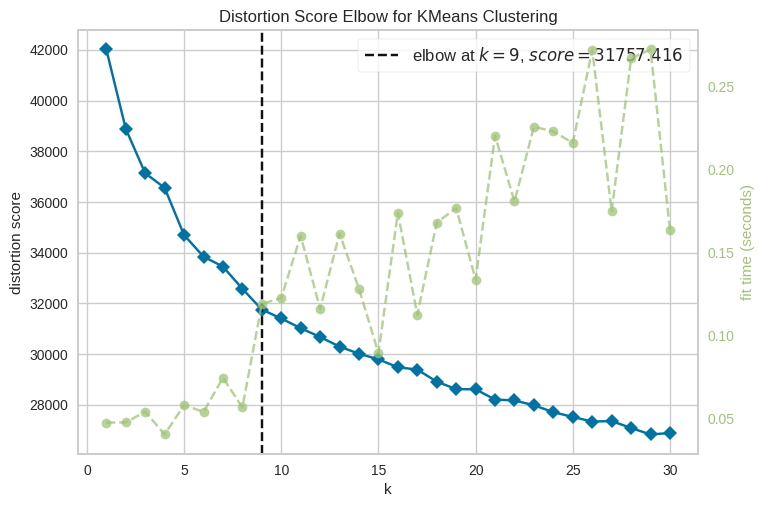

In [223]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
kemans_model = KMeans()
visualizer = KElbowVisualizer(kemans_model, k=(1,31))
visualizer.fit(df_clustered)  # Fit the data to the visualizer
visualizer.show()  # Finalize the plot
plt.show()

The visualization shows that the best `k_cluster` is 9 with WCSS score `31757.416`. we'll use that parameter and evaluate the silhouette score.

In [227]:
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(df_clustered)

kmeans_labels = kmeans.labels_
score = silhouette_score(df_clustered, kmeans_labels)
print(f'Silhouette Score: {score}')


Silhouette Score: 0.05699400913907192


## **c. Feature Selection (Opsional)**

We will select the most relevant feautures for our model, and we drop the unrelevant columns for good cluster prediction

To do feature selection we can try the following strategies:
1. Drop Features with High Multicollinearity
2. Drop Featrues with low variance
3. PCA (principle component analysis)

### C.1 Drop Features with low variance

<Axes: >

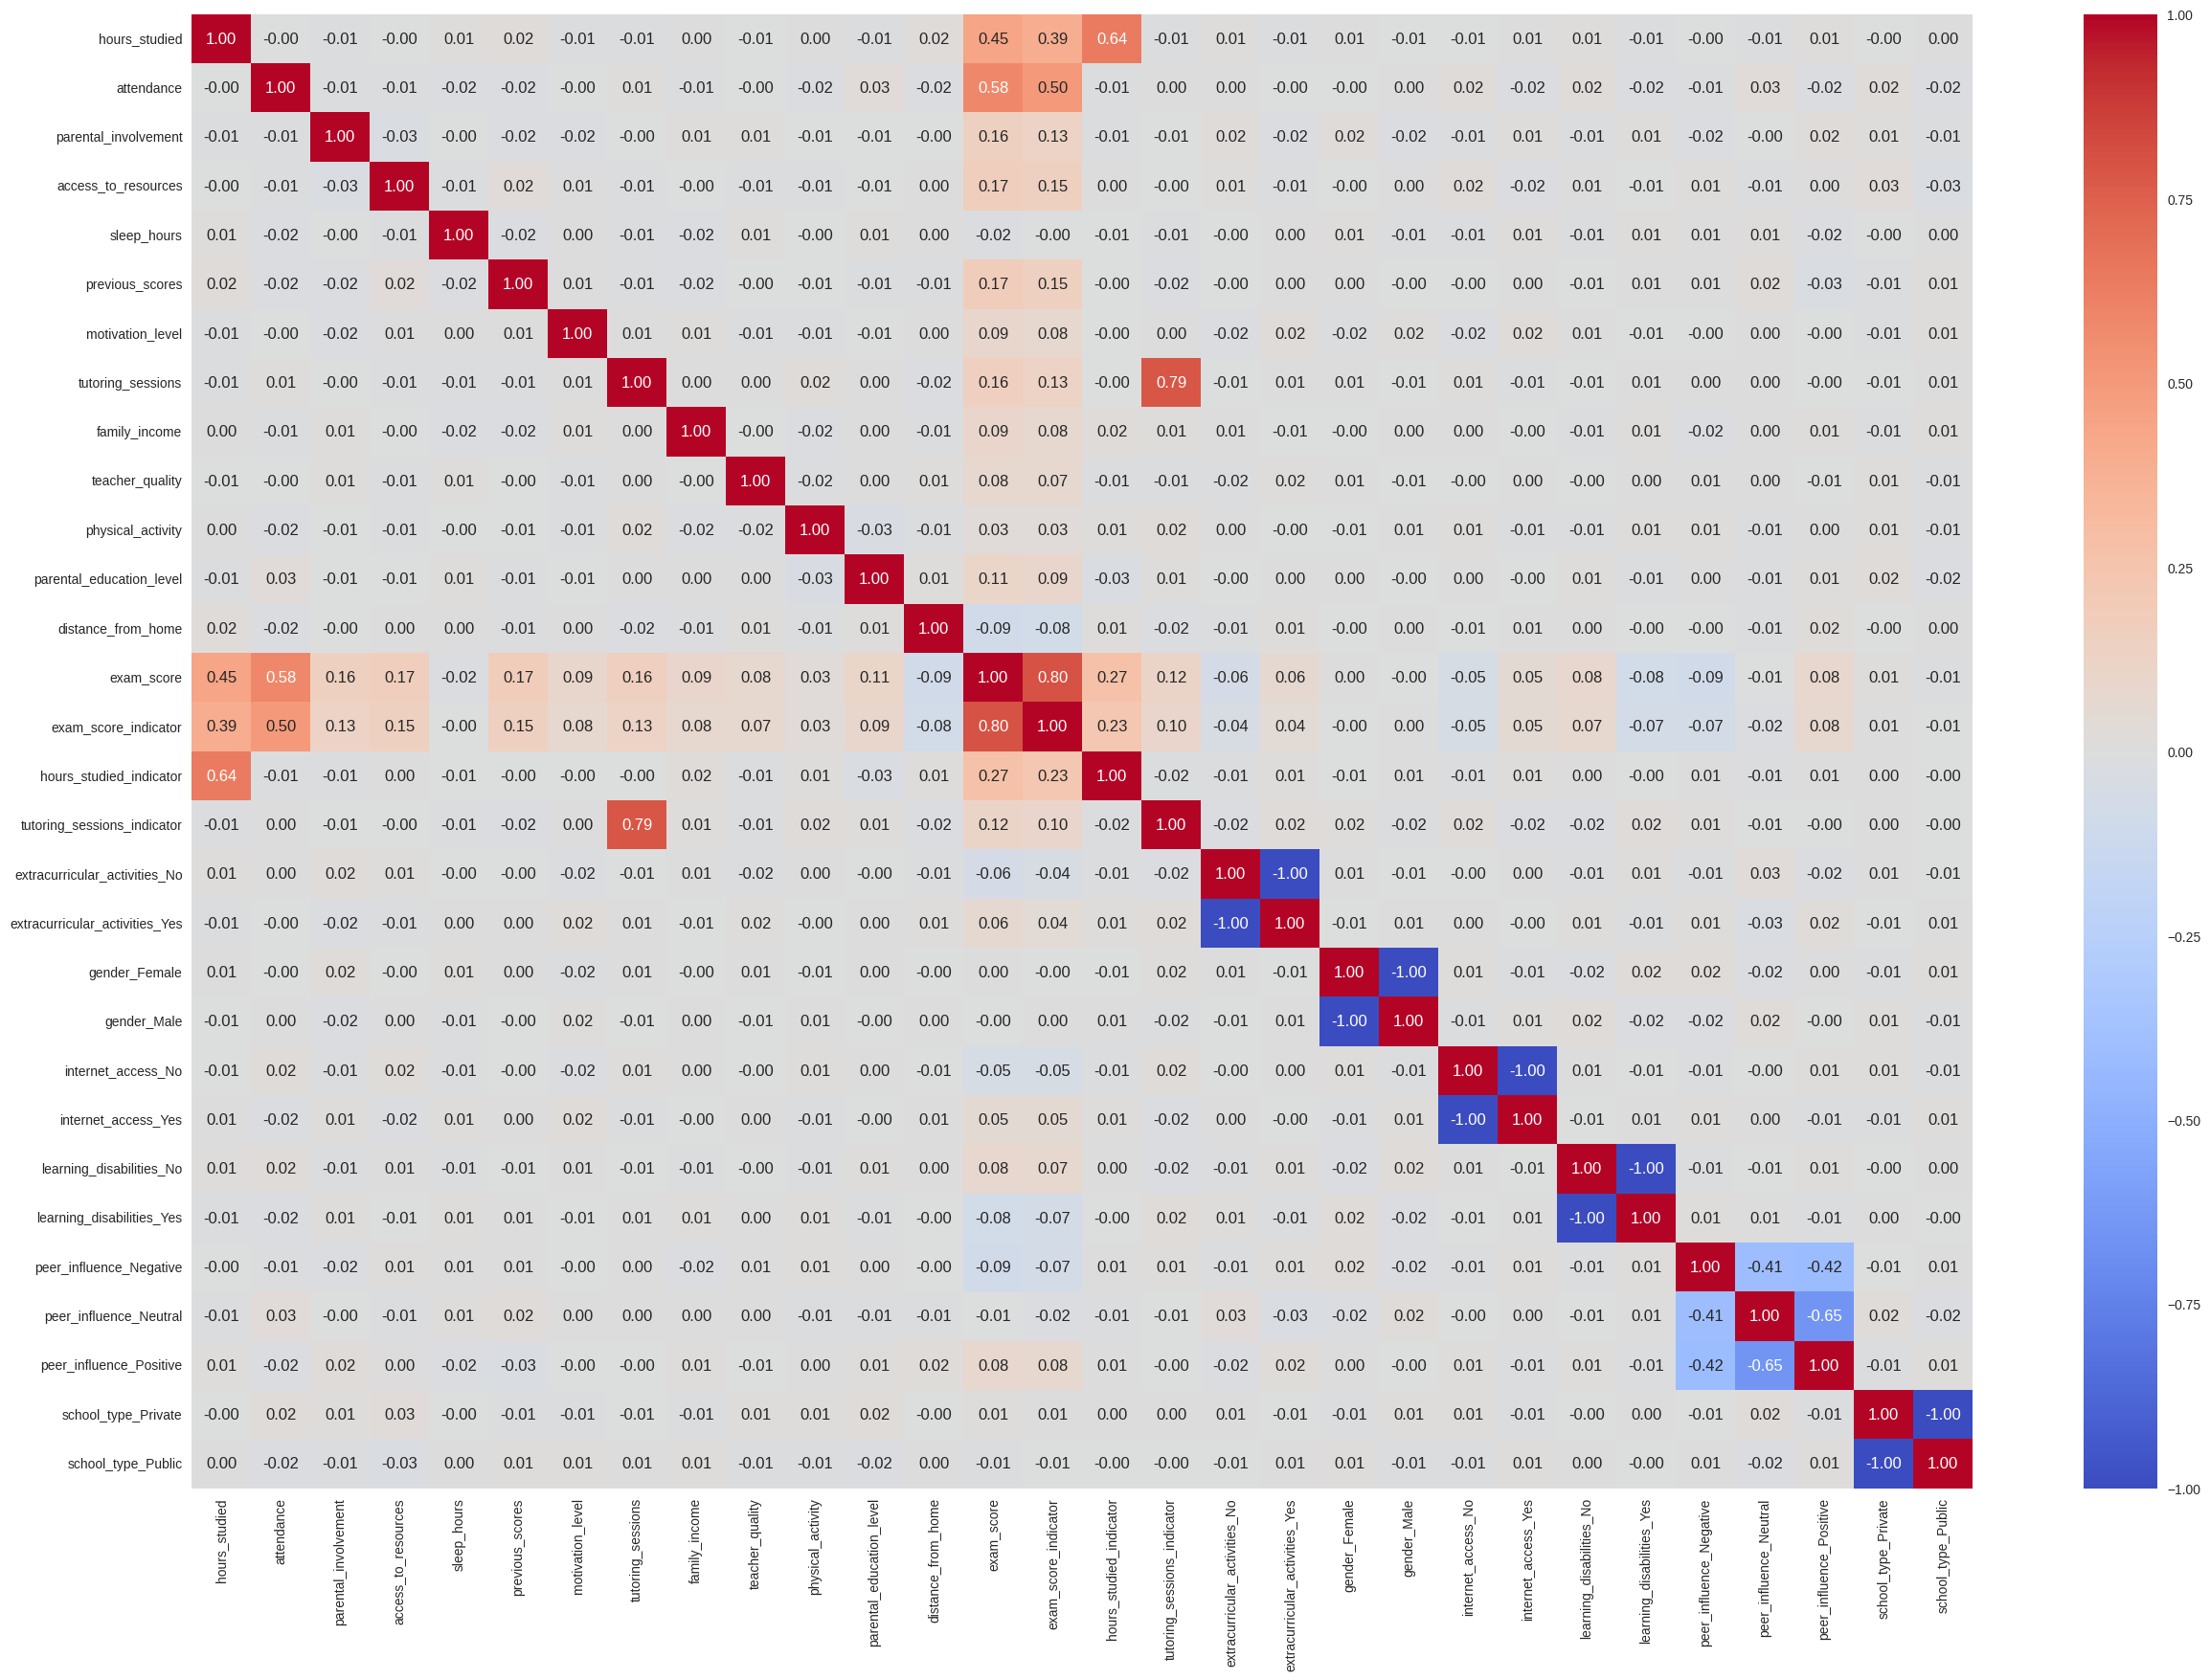

In [229]:
mat_corr = df_clustered.corr()
plt.figure(figsize=(30,20))
sns.heatmap(mat_corr, annot=True, fmt='.2f', cmap='coolwarm')

There is some features indicated as high correlation. we'll see further which one that we need to drop based on the lower variance of the features.

### C.3 Low Variance

Low variance means the feautre does not share the high variaty of data.

**STRATEGY**
1. Sort the variance from highest to lowest
2. Drop the features with the low variance with threshold < 0.5

In [231]:
features_var = np.var(df_clustered, axis=0).sort_values(ascending=False)
features_var = pd.Series(features_var, index=df_clustered.columns).sort_values(ascending=False)
print(f'feature variances: ')
features_var

feature variances: 


,0
parental_education_level,0.609193
family_income,0.552745
access_to_resources,0.488015
motivation_level,0.484004
parental_involvement,0.482977
distance_from_home,0.449421
teacher_quality,0.361222
gender_Female,0.243879
gender_Male,0.243879
extracurricular_activities_Yes,0.240611


In [255]:
df_selected = df_clustered.loc[:, features_var > 0.5]
df_selected

,family_income,parental_education_level
0,0,0
1,1,1
2,1,2
3,1,0
4,1,1
...,...,...
6602,2,0
6603,0,0
6604,0,2
6605,0,0


The selected feature that specify the threshold value above 0.5 is `family_income` and `parental_education_level`. Below let's check `DBSCAN` and `KMenas` model for selected features

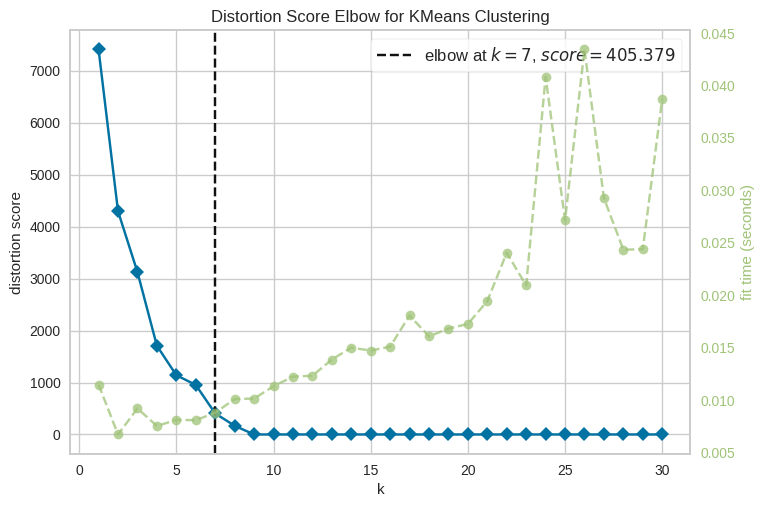

In [256]:
kmeans_selected = KMeans()
visualizer = KElbowVisualizer(kmeans_selected, k=(1,31))
visualizer.fit(df_selected)  # Fit the data to the visualizer
visualizer.show()  # Finalize the plot
plt.show()

In [257]:
def dbscan_kmeans_score(df, eps=0.5, min_samples=5, n_clusters=7, random_state=42):
    dbscan= DBSCAN()
    dbscan.fit(df)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(df)

    dbscan_labels = dbscan.labels_
    kmeans_labels = kmeans.labels_

    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise_dbscan = list(dbscan_labels).count(-1)

    n_clusters_kmeans = len(set(kmeans_labels)) - (1 if -1 in kmeans_labels else 0)
    n_noise_kmeans = list(kmeans_labels).count(-1)

    score_dbscan = silhouette_score(df, dbscan_labels)
    score_kmeans = silhouette_score(df, kmeans_labels)

    print(f'Estimated number of clusters dbscan: {n_clusters_dbscan}')
    print(f'Estimated number of noise points dbscan: {n_noise_dbscan}')


    print(f'Estimated number of clusters kmeans: {n_clusters_kmeans}')
    print(f'Estimated number of noise points kmeans: {n_noise_kmeans}')

    print(f'Silhouette Score dbscan: {score_dbscan}')
    print(f'Silhouette Score kmeans: {score_kmeans}')

    return dbscan, kmeans, dbscan_labels, kmeans_labels

In [258]:
dbscan_selected, kmeans_selected, dbscan_labels_selected, kmeans_labels_selected = dbscan_kmeans_score(df_selected, n_clusters=9, random_state=42)

Estimated number of clusters dbscan: 9
Estimated number of noise points dbscan: 0
Estimated number of clusters kmeans: 9
Estimated number of noise points kmeans: 0
Silhouette Score dbscan: 1.0
Silhouette Score kmeans: 1.0


Good score, we've got the 1.0 score of dbscan while kmeans is also good with 0.883 score. now let's try pca method

Beside that, we will reduce the features to 2 dimension using PCA method

In [275]:
pca = PCA(n_components=2, random_state=42)
pca.fit(df_clustered)
pca.explained_variance_ratio_

array([0.09328035, 0.08483805])

In [276]:
df_reduced = pca.transform(df_clustered)
df_reduced = pd.DataFrame(df_reduced, columns=['pca_1', 'pca_2'])
df_reduced

,pca_1,pca_2
0,-0.786740,-0.824447
1,0.213436,-0.116880
2,1.339703,0.245378
3,-0.622523,0.128478
4,0.393428,0.329966
...,...,...
6373,-0.663287,1.434245
6374,-0.743535,-0.488169
6375,1.196447,-0.972804
6376,-0.610790,-0.684916


Now let's create an elbow from reduced dataset using pca

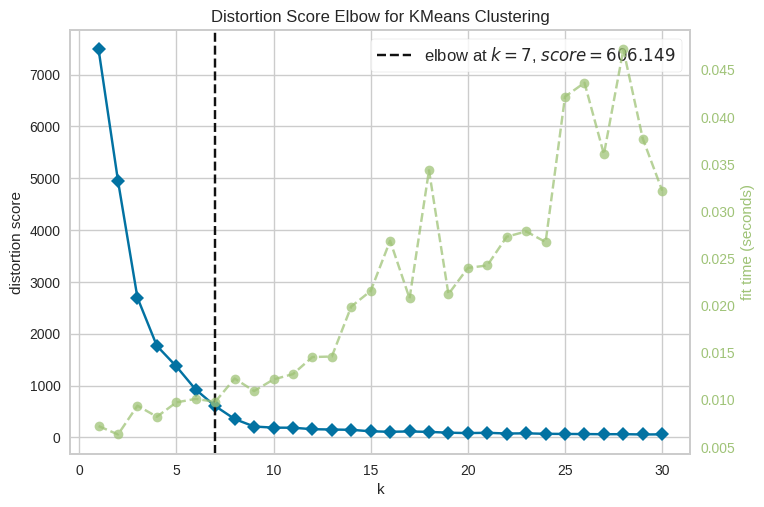

In [261]:
kmeans_reduced = KMeans()
visualizer = KElbowVisualizer(kmeans_reduced, k=(1,31))
visualizer.fit(df_reduced)  # Fit the data to the visualizer
visualizer.show()  # Finalize the plot
plt.show()

In [277]:
dbscan_reduced, kmeans_reduced, dbscan_labels_reduced, kmeans_labels_reduced= dbscan_kmeans_score(df_reduced, n_clusters=9, random_state=42)

Estimated number of clusters dbscan: 3
Estimated number of noise points dbscan: 0
Estimated number of clusters kmeans: 9
Estimated number of noise points kmeans: 0
Silhouette Score dbscan: 0.3828767206855684
Silhouette Score kmeans: 0.7433248355905111


The score for dbscan model of dataset reduced using pca is still low. We can tune it to find the best parameters for the best socre. code below is the function to tune the dbscan hyperparameters. May take a 5-7 minutes to run. So enjoy the coffee 🧋

In [278]:
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
min_samples_values = [i for i in range(1, 20)]


def tune_dbscan(df_clustered, eps_values, min_samples_values):
    start_time = time.time()
    best_score = -1
    best_params = None

    # Iterate over all combinations of eps and min_samples
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Initialize and fit DBSCAN with current parameters
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan.fit(df_clustered)
            labels = dbscan.labels_

            # Check if there are at least 2 clusters to calculate silhouette score
            if len(set(labels)) > 1:
                score = silhouette_score(df_clustered, labels)

                # check if score greater than target threshold min_score=0.55
                if score > 0.54:
                    n_cluster_ = len(set(labels)) - (1 if -1 in labels else 0)
                    n_noise_ = list(labels).count(-1)

                    score = score
                    params = {'eps': eps, 'min_samples': min_samples}

                    print(f'----------------------------------------')
                    print(f"Estimated number of clusters: {n_cluster_}")
                    print(f"Estimated number of noise points: {n_noise_}")
                    print('score:', score)
                    print(f'params: {params}')

                # Check if the score is the greater than prev score, and store it as best_score
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}


    # Output the best parameters and the highest silhouette score
    print("Best Parameters:", best_params)
    print("Best Silhouette Score:", best_score)
    print("--- %s seconds ---" % (time.time() - start_time))

In [279]:
tune_dbscan(df_reduced, eps_values, min_samples_values)

----------------------------------------
Estimated number of clusters: 9
Estimated number of noise points: 9
score: 0.5581778757981554
params: {'eps': 0.1, 'min_samples': 2}
----------------------------------------
Estimated number of clusters: 8
Estimated number of noise points: 11
score: 0.6469726692263716
params: {'eps': 0.1, 'min_samples': 3}
----------------------------------------
Estimated number of clusters: 8
Estimated number of noise points: 12
score: 0.6467429005002561
params: {'eps': 0.1, 'min_samples': 4}
----------------------------------------
Estimated number of clusters: 9
Estimated number of noise points: 13
score: 0.5824142193097526
params: {'eps': 0.1, 'min_samples': 5}
----------------------------------------
Estimated number of clusters: 8
Estimated number of noise points: 17
score: 0.6468795163759584
params: {'eps': 0.1, 'min_samples': 6}
----------------------------------------
Estimated number of clusters: 8
Estimated number of noise points: 17
score: 0.6468795

Indicated for the best :
- **Best Parameters**: {'eps': 0.1, 'min_samples': 8}
- **Best Silhouette Score**: 0.7411470675311188

In [280]:
dbscan_reduced = DBSCAN(eps=0.1, min_samples=8)
dbscan_reduced.fit(df_reduced)
dbscan_labels_reduced = dbscan_reduced.labels_
n_clusters = len(set(dbscan_labels_reduced)) - (1 if -1 in dbscan_labels_reduced else 0)
n_noise = list(dbscan_labels_reduced).count(-1)

score = silhouette_score(df_reduced, dbscan_labels_reduced)
print(f'Silhouette Score: {score}')
print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Silhouette Score: 0.7411470675311188
Estimated number of clusters: 9
Estimated number of noise points: 18


## **d. Visualisasi Hasil Clustering**

After the clustering model is trained and the optimal number of clusters is determined, the next step is to display the clustering results through visualization.

Here are the for the steps.
1. Display the clustering results in the form of visualizations, such as scatter plot graphs or 2D PCA projections.

In [281]:
df_reduced.head()

,pca_1,pca_2
0,-0.786740,-0.824447
1,0.213436,-0.116880
2,1.339703,0.245378
3,-0.622523,0.128478
4,0.393428,0.329966


We're plotting the points for the particular cluster and find the mean or the average for determine the center point of cluster

In [282]:
y_dbscan_reduced = dbscan_reduced.fit_predict(df_reduced)
dbscan_reduced_cluster = df_reduced.copy()
dbscan_reduced_cluster['cluster'] = y_dbscan_reduced
dbscan_reduced_cluster_mean = dbscan_reduced_cluster.groupby('cluster').mean().iloc[1:]

kmeans_reduced = KMeans(n_clusters=9, random_state=42)
y_kmeans_reduced = kmeans_reduced.fit_predict(df_reduced)
kmeans_reduced_cluster = df_reduced.copy()
kmeans_reduced_cluster['cluster'] = y_kmeans_reduced
kmeans_reduced_cluster_mean = kmeans_reduced_cluster.groupby('cluster').mean()

dbscan_reduced_cluster_mean, kmeans_reduced_cluster_mean

(            pca_1     pca_2
 cluster                    
 0       -0.750513 -0.725001
 1        0.309772  0.196415
 2        1.300916  0.125238
 3       -0.690439  0.253949
 4       -0.631121  1.228944
 5        1.245964 -0.853623
 6        0.370414  1.169379
 7        0.242907 -0.795434
 8        1.363222  1.098569,
             pca_1     pca_2
 cluster                    
 0       -0.750454 -0.725116
 1        1.363222  1.098569
 2        0.309149  0.196400
 3       -0.690376  0.253937
 4        0.242262 -0.797044
 5        1.245772 -0.852871
 6        0.371310  1.170451
 7        1.299797  0.122145
 8       -0.630754  1.229727)

In [283]:
y_dbscan_selected = dbscan_selected.fit_predict(df_selected)
dbscan_selected_cluster = df_selected.copy()
dbscan_selected_cluster['cluster'] = y_dbscan_selected
dbscan_selected_cluster_mean = dbscan_selected_cluster.groupby('cluster').mean()

y_kmeans_selected = kmeans_selected.fit_predict(df_selected)
kmeans_selected_cluster = df_selected.copy()
kmeans_selected_cluster['cluster'] = y_kmeans_selected
kmeans_selected_cluster_mean = kmeans_selected_cluster.groupby('cluster').mean()

dbscan_selected_cluster_mean, kmeans_selected_cluster_mean

(         family_income  parental_education_level
 cluster                                         
 0                  0.0                       0.0
 1                  1.0                       1.0
 2                  1.0                       2.0
 3                  1.0                       0.0
 4                  2.0                       0.0
 5                  0.0                       2.0
 6                  2.0                       1.0
 7                  0.0                       1.0
 8                  2.0                       2.0,
          family_income  parental_education_level
 cluster                                         
 0                  0.0                       0.0
 1                  1.0                       2.0
 2                  1.0                       0.0
 3                  0.0                       1.0
 4                  2.0                       0.0
 5                  0.0                       2.0
 6                  1.0                       1.0

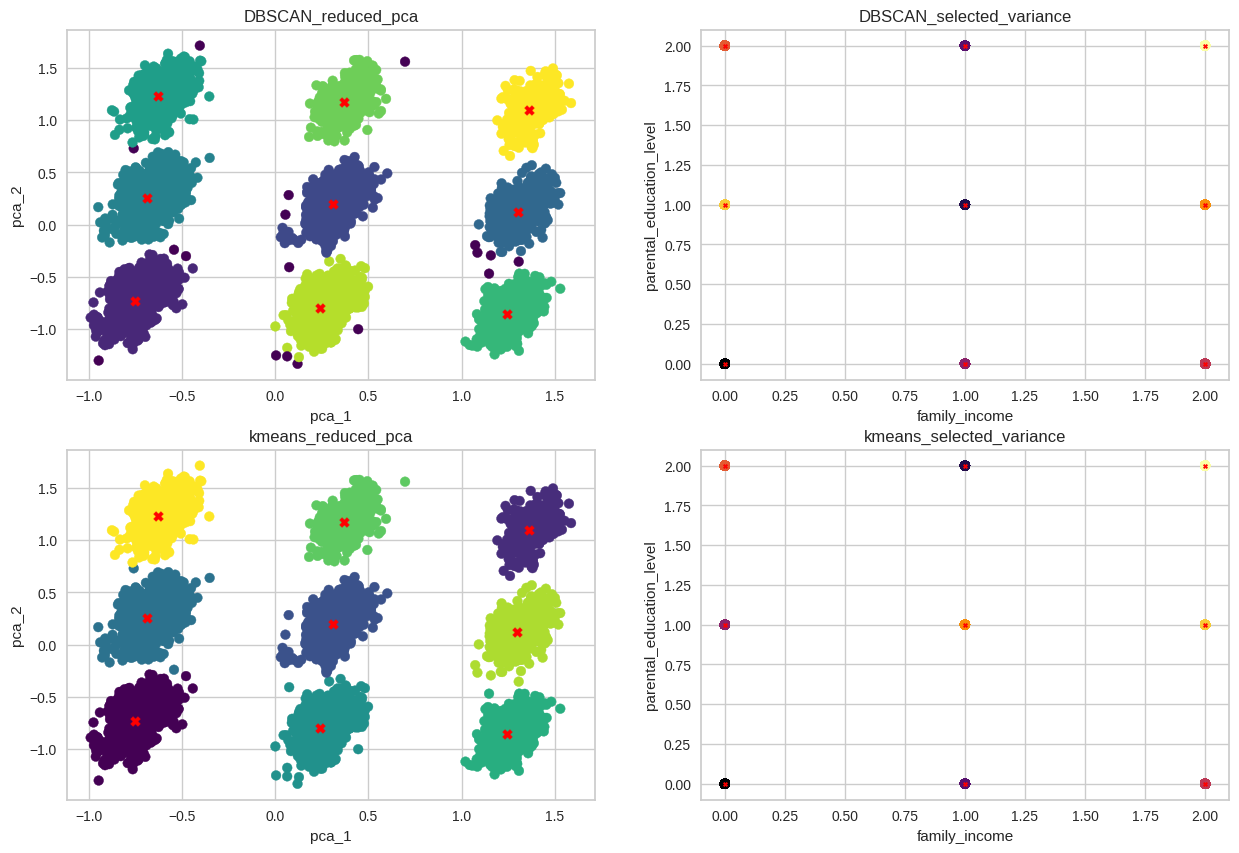

In [268]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

axes[0].scatter(df_reduced['pca_1'], df_reduced['pca_2'], c=dbscan_labels_reduced, cmap='viridis')
axes[0].scatter(dbscan_reduced_cluster_mean['pca_1'], dbscan_reduced_cluster_mean['pca_2'], c='red', cmap='viridis', marker='X')
axes[0].set_xlabel('pca_1')
axes[0].set_ylabel('pca_2')
axes[0].set_title('DBSCAN_reduced_pca')

axes[1].scatter(df_selected['family_income'], df_selected['parental_education_level'], c=dbscan_labels_selected, cmap='inferno')
axes[1].scatter(dbscan_selected_cluster_mean['family_income'], dbscan_selected_cluster_mean['parental_education_level'], c='red', cmap='inferno', marker='X', s=10)
axes[1].set_xlabel('family_income')
axes[1].set_ylabel('parental_education_level')
axes[1].set_title('DBSCAN_selected_variance')

axes[2].scatter(df_reduced['pca_1'], df_reduced['pca_2'], c=kmeans_labels_reduced, cmap='viridis')
axes[2].scatter(kmeans_reduced_cluster_mean['pca_1'], kmeans_reduced_cluster_mean['pca_2'], c='red', cmap='viridis', marker='X')
axes[2].set_xlabel('pca_1')
axes[2].set_ylabel('pca_2')
axes[2].set_title('kmeans_reduced_pca')

axes[3].scatter(df_selected['family_income'], df_selected['parental_education_level'], c=kmeans_labels_selected, cmap='inferno')
axes[3].scatter(kmeans_selected_cluster_mean['family_income'], kmeans_selected_cluster_mean['parental_education_level'], c='red', cmap='inferno', marker='X', s=10)
axes[3].set_xlabel('family_income')
axes[3].set_ylabel('parental_education_level')
axes[3].set_title('kmeans_selected_variance')

plt.show()

We have found 9 clusters of reduced features from pca, and selected features from variance. Both shows the good score of clustering. However, PCA is harder to interpret than variance. Which is why we choose variance-based clustering. From that, we have `family income` and `parental education level` as features and `kmeans` as a model.

## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [269]:
kmeans_selected_cluster_mean['family_income'] = kmeans_selected_cluster_mean['family_income'].apply(
    lambda x: 'Low' if x == 0.0 else 'Medium' if x == 1.0 else 'High'
)

kmeans_selected_cluster_mean['parental_education_level'] = kmeans_selected_cluster_mean['parental_education_level'].apply(
    lambda x: 'High School' if x == 0.0 else 'College' if x == 1.0 else 'Postgraduate'
)

kmeans_selected_cluster_mean

,family_income,parental_education_level
cluster,,
0,Low,High School
1,Medium,Postgraduate
2,Medium,High School
3,Low,College
4,High,High School
5,Low,Postgraduate
6,Medium,College
7,High,College
8,High,Postgraduate


In [270]:
df_labeled = df_cleaned.copy()
df_labeled['cluster'] = y_kmeans_selected
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   hours_studied                6378 non-null   int64 
 1   attendance                   6378 non-null   int64 
 2   parental_involvement         6378 non-null   object
 3   access_to_resources          6378 non-null   object
 4   extracurricular_activities   6378 non-null   object
 5   sleep_hours                  6378 non-null   int64 
 6   previous_scores              6378 non-null   int64 
 7   motivation_level             6378 non-null   object
 8   internet_access              6378 non-null   object
 9   tutoring_sessions            6378 non-null   int64 
 10  family_income                6378 non-null   object
 11  teacher_quality              6378 non-null   object
 12  school_type                  6378 non-null   object
 13  peer_influence               6378 non-

In [271]:
cluster_analysis = df_labeled.groupby('cluster').agg({
    'exam_score' : ['mean', 'max', 'min'],
    'attendance' : ['mean', 'max', 'min'],
    'cluster' : 'count'
})

cluster_analysis.columns = ['_'.join(col).strip() for col in cluster_analysis.columns.values]
for col in ['exam_score_mean', 'attendance_mean']:
  cluster_analysis[col] = cluster_analysis[col].round(3)

cluster_analysis.rename(columns={'cluster_count': 'frequency'}, inplace=True)
cluster_analysis

,exam_score_mean,exam_score_max,exam_score_min,attendance_mean,attendance_max,attendance_min,frequency
cluster,,,,,,,
0,66.496,97,55,79.925,100,60,1286
1,67.900,93,58,79.706,100,60,521
2,67.045,99,57,79.644,100,60,1254
3,66.860,94,56,79.888,100,60,784
4,67.417,100,59,79.591,100,60,619
5,67.740,95,57,81.461,100,60,512
6,67.539,98,58,80.351,100,60,791
7,68.041,100,60,80.148,100,60,364
8,68.607,98,61,80.360,100,60,247


Text(0.5, 1.0, 'Frequency of Clusters')

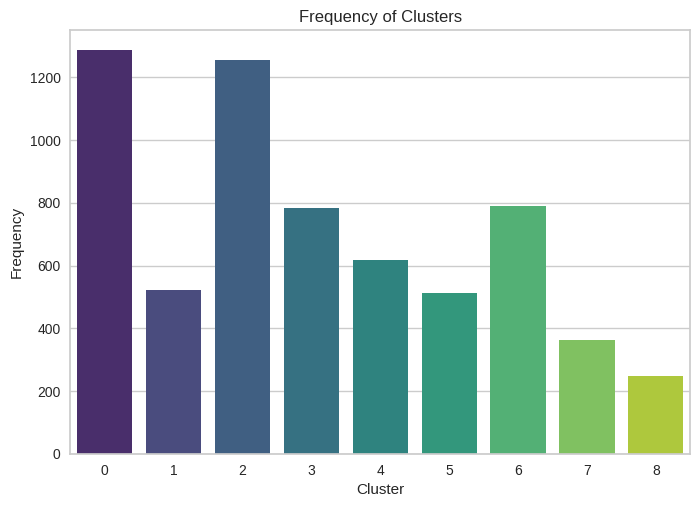

In [272]:
sns.countplot(x='cluster', data=df_labeled, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Frequency of Clusters')

Tulis hasil interpretasinya di sini.
1. Cluster 0:
    - ****Family_income**** = Low
    - ****Parental_education_level**** = Postgraduate
    - **Rata-rata exam score** = 66,496
    - **Rata-rata attendance** = 79,925
    - **Frekuensi** = 1286
    - **Analisis**: Kluster 1 memiliki nilai **family_income** yang rendah dan **parental_education_level** yang tinggi (postgraduate). Kemungkinan demografi pada siswa ini memungkinan tidak seimbangnya antara akonomi dan pencapaian pada pendidikannya, atau seorang orang tua yang lebih memfokuskan edukasi yang tinggi dari pada income yang tinggi.
2. Cluster 1:
    - ****Family_income**** = Medium
    - ****Parental_education_level**** = High School
    - **Rata-rata exam score** = 67.900
    - **Rata-rata attendance** = 79.706
    - **Frekuensi** = 521
    - **Analisis** = Kluster 2 memiliki nilai **family_income** yang tinggi dan **parental_education_level** yang tinggi (high school). Siswa ini memiliki keluarga yang mungkin memiliki kemampuan teknikal yang dapat meningkatkan income dan kestabilan ekonominya.
3. Cluster 2:
    - ****Family_income**** = High
    - **Parental_education_level** = College
    - **Rata-rata exam score** = 67.045
    - **Rata-rata attendance** = 79.644
    - **Frekuensi** = 1254
    - **Analisis** =  Kluster ini merepresentasikan keluarga yang memiliki income tinggi dan kemampuan intelektual yang tinggi. Sehingga dapat pekerjaan yang layak sesuai dari jurusan pendidikan yang diampu, seperti: management, engineering, atau spesialis.
4. Cluster 3:
    - **Family_income** = Low
    - **Parental_education_level** = High school
    - **Rata-rata exam score** = 66.860
    - **Rata-rata attendance** = 79.888
    - **Frekuensi** = 784
    - **Analisis** =  Kluster yang mempresentasikan keluarga dengan pemasukan yang rendah dan tingkat pendidikan yang rendah. Hal itu dapat mengindikasikan kelemahan ekonomi dan terbatasnya lapangan pekerjaan yang tersedia.
5. Cluster 4:
    - **Family_income** = Medium
    - **Parental_education_level** = College
    - **Rata-rata exam score** = 67.417
    - **Rata-rata attendance** = 79.591
    - **Frekuensi** = 619
    - **Analisis** = Kluster merepresentasikan potensial dari middle-class dimana yang dapat gaji yang stabil, pekerjaan ini seperti, guru atau Professional tingkat pemula
6. Cluster 5:
    - **Family_income** = Low
    - **Parental_education_level** = College
    - **Rata-rata exam score** = 67.740
    - **Rata-rata attendance** = 81.461
    - **Frekuensi** = 512
    - **Analisis**  Kluster ini menggambarkan, walau orang tua yang memiliki pendidikan yang tinggi, kluster ini memungkinkan underemployment, dimana pekerjaan yang mereka dapat tidak sesuai dengan gelar pendidikan yang didapatkan, atau mereka tinggal di wilayah yang pendapatan daerahnya rendah.
7. Cluster 6:
    - **Family_income** = High
    - **Parental_education_level** = High School
    - **Rata-rata exam score** = 67.539
    - **Rata-rata attendance** = 80.351
    - **Frekuensi** = 791
    - **Analisis** Kluster ini meskipun mempunyai pendidikan yang rendah, akan tetapi mempunyai income yang tinggi, ini memungkinkan seorang pengusaha, mempunyai warisan, atau kemampuan dalam berdagang yang tidak dimiliki oleh seorang yang pendidikan tinggi
8. Cluster 7:
    - **Family_income** = Medium
    - **Parental_education_level** = Postgraduate
    - **Rata-rata exam score** = 68.041
    - **Rata-rata attendance** = 80.148
    - **Frekuensi** = 364
    - **Analisis** = Kelompok ini mencakup keluarga dengan pendapatan sedang dan pendidikan pascasarjana. Ini mungkin menunjukkan profesi di bidang pendidikan, penelitian, atau layanan publik, yang sering kali memerlukan gelar lanjutan tetapi tidak selalu menawarkan gaji tinggi.
9. Cluster 8:
    - **Family_income** = High
    - **Parental_education_level** = Postgraduate
    - **Rata-rata exam score** = 68.607
    - **Rata-rata attendance** = 80.360
    - **Frekuensi** = 247
    - **Analisis** = Kelompok ini kemungkinan besar terdiri dari keluarga yang berpendidikan tinggi dan berpenghasilan tinggi. Orang tua dalam kelompok ini mungkin memiliki profesi bergengsi atau bergaji tinggi, seperti dokter, pengacara, atau eksekutif perusahaan.


# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [273]:
df_labeled.to_csv('data-labeled.csv')

In [274]:
from google.colab import files
files.download('data-labeled.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>